In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from geopy.distance import geodesic
import folium
import math
import io
import json

In [2]:
# Foi feita a média de 10 coletas estáticas no centro de rotação do pivô com o esp32 e ficou um pouco diferente do artigo. 
# Usarei a medida coletada, pois ao plotar no folium, é dada uma coordenada errada do centro do pivo pelo artigo
# lat_medida = -22,7134209
# long_medida = -47,6284572

# lat_artigo = -22.7132778 --- > 22°42’47.8” S
# long_artigo = -47.6291389 ---> 47°37’44.9” W

# Coordenadas para posicionar o mapa do folium no pivô
pivot_lat = -22.7134209
pivot_long = -47.6284572

# Pontos Referência Pivô

In [3]:
# Dados do novo centro
radius_m = 10.23  # raio do círculo em metros
num_points = 720

# Constantes de conversão
meters_per_degree_lat = 111320  # metros por grau latitude
meters_per_degree_lon = meters_per_degree_lat * math.cos(math.radians(pivot_lat))  # metros por grau longitude ajustado

# Lista para armazenar os pontos do novo círculo
circle_points_pivot = []

for i in range(num_points):
    angle_deg = i * (360/num_points)
    angle_rad = math.radians(angle_deg)

    delta_lat = (radius_m * math.cos(angle_rad)) / meters_per_degree_lat
    delta_lon = (radius_m * math.sin(angle_rad)) / meters_per_degree_lon

    new_lat = pivot_lat + delta_lat
    new_lon = pivot_long + delta_lon

    circle_points_pivot.append({"latitude": new_lat, "longitude": new_lon, "angle_deg": angle_deg})

# Criar DataFrame e salvar como CSV
df_pivot_circle = pd.DataFrame(circle_points_pivot)
df_pivot_circle.to_csv("Dados/pontos_referencia_pivo.csv", index=False)

In [4]:
# Carregando as coordenadas projetadas no utilizando o centro do pivo
df_pivot = pd.read_csv('Dados/pontos_referencia_pivo.csv')
df_pivot

,latitude,longitude,angle_deg
0,-22.713329,-47.628457,0.0
1,-22.713329,-47.628456,0.5
2,-22.713329,-47.628455,1.0
3,-22.713329,-47.628455,1.5
4,-22.713329,-47.628454,2.0
...,...,...,...
715,-22.713329,-47.628462,357.5
716,-22.713329,-47.628461,358.0
717,-22.713329,-47.628460,358.5
718,-22.713329,-47.628459,359.0


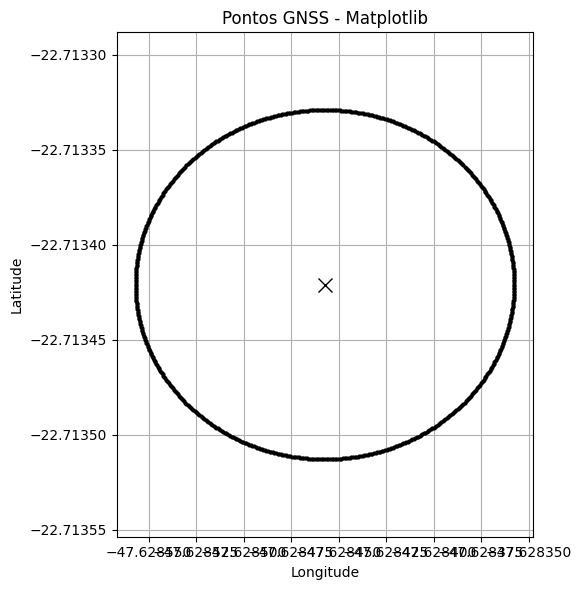

In [5]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(df_pivot["longitude"], df_pivot["latitude"], marker='o', linestyle="", markersize=2, color='black')
ax.plot(pivot_long, pivot_lat, marker='x', color='black', markersize=10, label='Ponto de Pivô')
ax.set_title("Pontos GNSS - Matplotlib")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
ax.axis("equal")  # Mantém proporção correta
ax.ticklabel_format(useOffset=False)  # <--- ESSA LINHA REMOVE O OFFSET

plt.tight_layout()
plt.show()


In [6]:
# Adiciona os pontos como marcadores circulares
# Criar o mapa centralizado na sua coordenada
map_reference = folium.Map(location=[pivot_lat, pivot_long], zoom_start=14)

for _, row in df_pivot.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=2,
        color="black",
        fill=True,
        fill_opacity=0.7,
        popup=f'Ângulo: {row["angle_deg"]}°'
    ).add_to(map_reference)

folium.CircleMarker(
    location=[pivot_lat, pivot_long],
    radius=2,
    color="black",
    fill=True,
    fill_opacity=0.7,
    popup=f'Ângulo: {row["angle_deg"]}°'
).add_to(map_reference)

# Salva o mapa em HTML
map_reference.save("mapa_pivo_referencia.html")

# Ensaios Realizados

Os ensaios estão organizados da seguinte forma:

- ❌ Volta 1: 12,5 Hz (o esp32 não coletou por conta de problemas na rede de energia, nos proximos foi usado um powerbank)   --> 23/04/25 11:28 até 12:38
- ✅ Volta 2: 12,5 Hz (todos os equipamentos coletaram)   --> 23/04/25 15:51 até 17:01
- ❌ Volta 3: 12,5 Hz (o app SW Maps não coletou)         --> 24/04/25 14:55 até 16:05
- ✅ Volta 4: 25 Hz (todos os equipamentos coletaram)     --> 25/04/25 9:20 até 10:30
- ✅ Volta 5: 25 Hz (todos os equipamentos coletaram)     --> 25/04/25 10:50 até 12:00


- ✅ Volta 6: 25 Hz (todos os equipamentos coletaram)     --> 25/04/25 12:25 até 13:35
- ✅ Volta 7: 12,5 Hz (todos os equipamentos coletaram)   --> 25/04/25 13:58 até 15:08
- ✅ Volta 8: 12,5 Hz (todos os equipamentos coletaram)   --> 25/04/25 15:50 até 17:00

12,5 Hz no inversor corresponde a 2,5 m/s
25 Hz no inversor corresponde a 5 m/s

Foram feitas coletas pontuais antes da volta 4, contudo o método utilizado para coleta foi de 1:10h de coleta e 20m de pausa para dar tempo de mudar a constelação dos satélites. A volta 2 irá compor a volta faltante para a situação de 12,5 HZ.

Os dados foram coletados a cada 5 segundos (0,2Hz).

In [54]:
'''
Como houveram ensaios que nem todos os dispositivos conseguiram coletar, vou organizar da seguinte forma:

 - lap_1 = Volta 4
 - lap_2 = Volta 5
 - lap_3 = Volta 6
 - lap_4 = Volta 7
 - lap_5 = Volta 8
 - lap_6 = Volta 2

'''

laps = {
    "lap_1": {
        "lap_start": "2025-04-25 09:20",
        "lap_end": "2025-04-25 10:30",
        "esp32": {},
        "celular": {},
        "garmin": {}
    },
    "lap_2": {
        "lap_start": "2025-04-25 10:50",
        "lap_end": "2025-04-25 12:00",
        "esp32": {},
        "celular": {},
        "garmin": {}
    },
    "lap_3": {
        "lap_start": "2025-04-25 12:25",
        "lap_end": "2025-04-25 13:35",
        "esp32": {},
        "celular": {},
        "garmin": {}
    },
    "lap_4": {
        "lap_start": "2025-04-25 13:58",
        "lap_end": "2025-04-25 15:08",
        "esp32": {},
        "celular": {},
        "garmin": {}
    },
    "lap_5": {
        "lap_start": "2025-04-25 15:50",
        "lap_end": "2025-04-25 17:00",
        "esp32": {},
        "celular": {},
        "garmin": {}
    },
    "lap_6": {
        "lap_start": "2025-04-23 15:51",
        "lap_end": "2025-04-23 17:01",
        "esp32": {},
        "celular": {},
        "garmin": {}
    },
}

In [ ]:
'''
A estrtura que se busca montar é conforme o exemplo abaixo:


laps = {
    "volta_1": {
        "lap_start": "2025-04-25 09:20",
        "lap_end": "2025-04-25 10:30",
        "esp32": {
            "dataframe": df_esp32_volta_1,  # DataFrame com dados tratados do ESP32
            "erro_analysis": {
                "media_erro_m": 1.23,
                "desvio_erro_m": 0.45,
                "2sigma_m": 0.90,
                "max_erro_m": 2.56,
                "min_erro_m": 0.11,
                "qtd_pontos": 85,
                "erros_metros": [1.1, 1.3, 1.0, ...]
            }
        },
        "celular": {
            "dataframe": df_celular_volta_1,
            "erro_analysis": {
                "media_erro_m": 2.34,
                "desvio_erro_m": 0.78,
                "2sigma_m": 1.56,
                "max_erro_m": 3.45,
                "min_erro_m": 0.89,
                "qtd_pontos": 90,
                "erros_metros": [2.0, 2.5, 2.1, ...]
            }
        },
        "garmin": {
            "dataframe": df_garmin_volta_1,
            "erro_analysis": {
                "media_erro_m": 0.97,
                "desvio_erro_m": 0.32,
                "2sigma_m": 0.64,
                "max_erro_m": 1.50,
                "min_erro_m": 0.50,
                "qtd_pontos": 92,
                "erros_metros": [0.8, 1.1, 1.0, ...]
            }
        }
    },
    "volta_2": {
        "lap_start": "2025-04-25 10:50",
        "lap_end": "2025-04-25 12:00",
        "esp32": {
            "dataframe": ...,
            "erro_analysis": {...}
        },
        "celular": {
            "dataframe": ...,
            "erro_analysis": {...}
        },
        "garmin": {
            "dataframe": ...,
            "erro_analysis": {...}
        }
    },
    ...
}
'''

'\nA estrtura que se busca montar é conforme o exemplo abaixo:\n\n\nlaps = {\n    "volta_1": {\n        "lap_start": "2025-04-25 09:20",\n        "lap_end": "2025-04-25 10:30",\n        "esp32": {\n            "dataframe": df_esp32_volta_1,  # DataFrame com dados tratados do ESP32\n            "erro_analysis": {\n                "media_erro_m": 1.23,\n                "desvio_erro_m": 0.45,\n                "2sigma_m": 0.90,\n                "max_erro_m": 2.56,\n                "min_erro_m": 0.11,\n                "qtd_pontos": 85,\n                "erros_metros": [1.1, 1.3, 1.0, ...]\n            }\n        },\n        "celular": {\n            "dataframe": df_celular_volta_1,\n            "erro_analysis": {\n                "media_erro_m": 2.34,\n                "desvio_erro_m": 0.78,\n                "2sigma_m": 1.56,\n                "max_erro_m": 3.45,\n                "min_erro_m": 0.89,\n                "qtd_pontos": 90,\n                "erros_metros": [2.0, 2.5, 2.1, ...]\n    

## ESP32

In [56]:

df_esp_250_1 = pd.read_csv('Dados/esp32_volta_4.csv') # 25Hz inversor = 2,5ms - lap_1
df_esp_250_2 = pd.read_csv('Dados/esp32_volta_5.csv') # 25Hz inversor = 2,5ms - lap_2
df_esp_250_3 = pd.read_csv('Dados/esp32_volta_6.csv') # 25Hz inversor = 2,5ms - lap_3

df_esp_125_1 = pd.read_csv('Dados/esp32_volta_7.csv') # 12,5Hz inversor = 2,5ms - lap_4
df_esp_125_2 = pd.read_csv('Dados/esp32_volta_8.csv') # 12,5Hz inversor = 2,5ms - lap_5
df_esp_125_3 = pd.read_csv('Dados/esp32_volta_2.csv') # 12,5Hz inversor = 2,5ms - lap_6


laps["lap_1"]["esp32"]["dataframe"] = df_esp_250_1
laps["lap_2"]["esp32"]["dataframe"] = df_esp_250_2
laps["lap_3"]["esp32"]["dataframe"] = df_esp_250_3
laps["lap_4"]["esp32"]["dataframe"] = df_esp_125_1
laps["lap_5"]["esp32"]["dataframe"] = df_esp_125_2
laps["lap_6"]["esp32"]["dataframe"] = df_esp_125_3

laps["lap_6"]["esp32"]["dataframe"]


,2025-04-23 15:54:15,2025-4-23 18:54:15,-22.713407,-47.628441,543.300000,0.87,10
0,2025-04-23 15:54:17,2025-4-23 18:54:16,-22.713423,-47.628442,543.2,0.87,10
1,2025-04-23 15:54:18,2025-4-23 18:54:17,-22.713440,-47.628447,543.1,0.87,10
2,2025-04-23 15:54:19,2025-4-23 18:54:19,-22.713468,-47.628464,543.1,0.87,10
3,2025-04-23 15:54:20,2025-4-23 18:54:20,-22.713479,-47.628477,543.4,0.87,10
4,2025-04-23 15:54:21,2025-4-23 18:54:21,-22.713489,-47.628491,543.4,0.87,10
...,...,...,...,...,...,...,...
3292,2025-04-23 16:54:10,2025-4-23 19:54:10,-22.713385,-47.628626,546.8,1.18,9
3293,2025-04-23 16:54:11,2025-4-23 19:54:11,-22.713372,-47.628616,546.9,0.93,10
3294,2025-04-23 16:54:12,2025-4-23 19:54:12,-22.713360,-47.628603,547.0,0.93,10
3295,2025-04-23 16:54:13,2025-4-23 19:54:13,-22.713351,-47.628588,546.9,0.93,10


In [82]:
# Percorrendo as chaves do dicionário, estou renomeando as colunas, cortando os dados capturados fora do range de lap_start e lap_end e
# diminuindo a frequência de coleta, pois o esp32 eu configurei para coletar a cada 1 seg e selecionei dados a cada 5 seg

for lap_name, lap_data in laps.items():
    # Verifica se há dados em esp32 e se "dataframe" está presente
    if "dataframe" in lap_data.get("esp32", {}):
        dataframe = lap_data["esp32"]["dataframe"]

        # Renomeia as colunas
        dataframe.columns = ['timestamp_net', 'timestamp_gps', 'latitude', 'longitude', 'altitude', 'hdop', 'satélites']
        
        # Converte a coluna 'timestamp_net' para datetime
        dataframe['timestamp_net'] = pd.to_datetime(dataframe['timestamp_net'])
        
        # Usa o lap_start e lap_end da volta como timestamps e tirando os 5 primeiros e os 5 últimos minutos
        start_time = pd.Timestamp(lap_data["lap_start"]) + pd.Timedelta(minutes=5)
        end_time = pd.Timestamp(lap_data["lap_end"]) - pd.Timedelta(minutes=5)
        
        # Filtra os dados dentro do intervalo de tempo da volta
        dataframe = dataframe[
            (dataframe['timestamp_net'] >= start_time) &
            (dataframe['timestamp_net'] <= end_time)
        ]
        
        # Ordena por timestamp e reseta o índice
        dataframe = dataframe.sort_values('timestamp_net').reset_index(drop=True)
        
        # Seleciona linhas com múltiplos de 5 segundos exatos a partir do start_time
        dataframe = dataframe[((dataframe['timestamp_net'] - start_time).dt.total_seconds() % 5 == 0)]
        
        # Atualiza o dataframe tratado no dicionário
        laps[lap_name]["esp32"]["dataframe"] = dataframe



In [83]:
laps["lap_1"]["esp32"]["dataframe"]

,timestamp_net,timestamp_gps,latitude,longitude,altitude,hdop,satélites
0,2025-04-25 09:25:00,2025-4-25 12:25:0,-22.713293,-47.628612,547.5,1.13,10
1,2025-04-25 09:25:05,2025-4-25 12:25:5,-22.713366,-47.628478,547.6,0.91,10
2,2025-04-25 09:25:10,2025-4-25 12:25:10,-22.713470,-47.628592,547.1,0.91,10
3,2025-04-25 09:25:15,2025-4-25 12:25:15,-22.713342,-47.628664,547.8,0.82,11
4,2025-04-25 09:25:20,2025-4-25 12:25:20,-22.713310,-47.628510,547.7,0.91,10
...,...,...,...,...,...,...,...
665,2025-04-25 10:24:35,2025-4-25 13:24:35,-22.713426,-47.628667,549.6,0.85,10
666,2025-04-25 10:24:40,2025-4-25 13:24:40,-22.713290,-47.628611,549.1,0.85,10
667,2025-04-25 10:24:50,2025-4-25 13:24:50,-22.713464,-47.628607,549.7,0.95,9
668,2025-04-25 10:24:55,2025-4-25 13:24:55,-22.713330,-47.628670,549.8,0.85,10


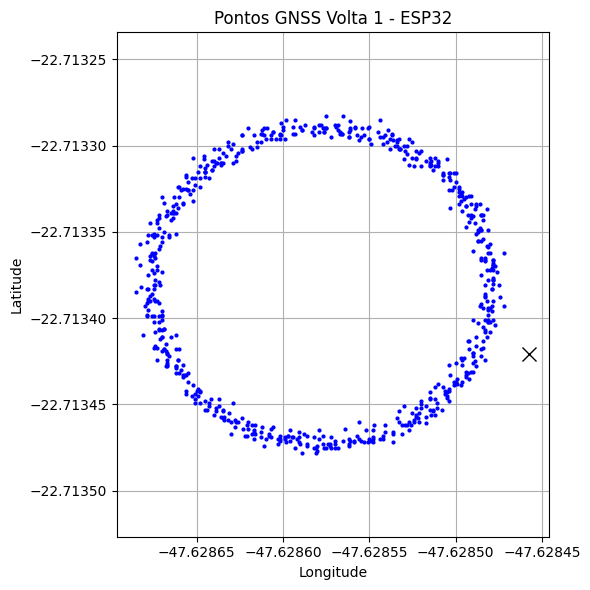

In [84]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot( laps['lap_1']["esp32"]["dataframe"]["longitude"], laps['lap_1']["esp32"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='blue')
ax.plot(pivot_long, pivot_lat, marker='x', color='black', markersize=10, label='Ponto de Pivô')
ax.set_title("Pontos GNSS Volta 1 - ESP32")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
ax.axis("equal")  # Mantém proporção correta
ax.ticklabel_format(useOffset=False)  # <--- ESSA LINHA REMOVE O OFFSET

plt.tight_layout()
plt.show()


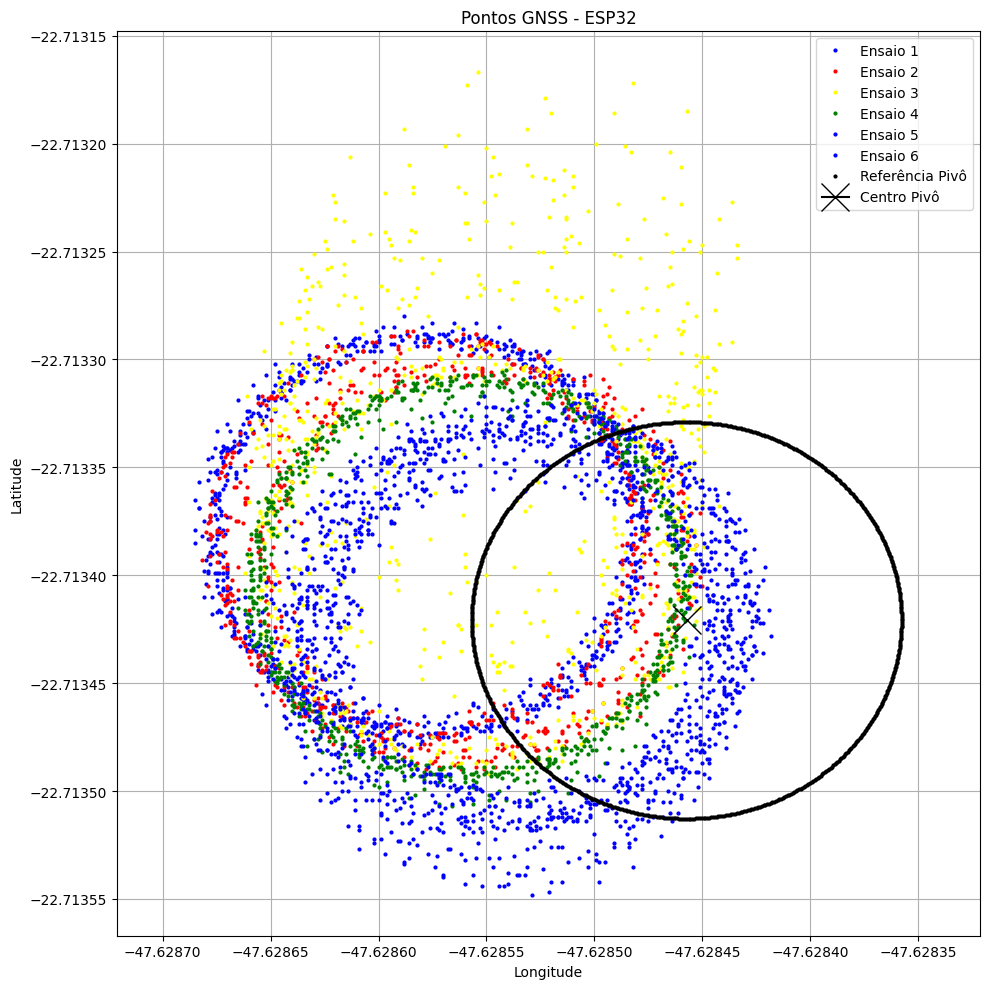

In [63]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot( laps['lap_1']["esp32"]["dataframe"]["longitude"], laps['lap_1']["esp32"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='blue', label="Ensaio 1")
ax.plot( laps['lap_2']["esp32"]["dataframe"]["longitude"], laps['lap_2']["esp32"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='red', label="Ensaio 2")
ax.plot( laps['lap_3']["esp32"]["dataframe"]["longitude"], laps['lap_3']["esp32"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='yellow', label="Ensaio 3")
ax.plot( laps['lap_4']["esp32"]["dataframe"]["longitude"], laps['lap_4']["esp32"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='green', label="Ensaio 4")
ax.plot( laps['lap_5']["esp32"]["dataframe"]["longitude"], laps['lap_5']["esp32"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='blue', label="Ensaio 5")
ax.plot( laps['lap_6']["esp32"]["dataframe"]["longitude"], laps['lap_6']["esp32"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='blue', label="Ensaio 6")
ax.plot(df_pivot["longitude"], df_pivot["latitude"], marker='o', linestyle="", markersize=2, color='black', label="Referência Pivô")
ax.plot(pivot_long, pivot_lat, marker='x', color='black', markersize=20, label="Centro Pivô")

ax.legend()

ax.set_title("Pontos GNSS - ESP32")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
ax.axis("equal")  # Mantém proporção correta
ax.ticklabel_format(useOffset=False)  # <--- ESSA LINHA REMOVE O OFFSET

plt.tight_layout()
plt.show()

In [64]:
# Primeiro, criar o mapa centralizado no seu pivô
map_esp32 = folium.Map(location=[pivot_lat, pivot_long], zoom_start=17, tiles="OpenStreetMap")

# Definindo as voltas, cores e nomes
laps_to_plot = ['lap_1', 'lap_2', 'lap_3', 'lap_4', 'lap_5', 'lap_6']
colors = ['blue', 'red', 'yellow', 'green', 'purple', 'orange']
labels = ['Ensaio 1', 'Ensaio 2', 'Ensaio 3', 'Ensaio 4', 'Ensaio 5', 'Ensaio 6']

# Adiciona os pontos de cada volta
for lap_name, color, label in zip(laps_to_plot, colors, labels):
    df_esp = laps[lap_name]["esp32"].get("dataframe")
    if df_esp is not None:
        for _, row in df_esp.iterrows():
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=2,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.7,
                popup=f"{label}"
            ).add_to(map_esp32)

# Adiciona os pontos de referência do pivô
for _, row in df_pivot.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.7,
        popup="Referência Pivô"
    ).add_to(map_esp32)

# Adiciona o centro do pivô
folium.Marker(
    location=[pivot_lat, pivot_long],
    icon=folium.Icon(color='black', icon='star'),
    popup="Centro Pivô"
).add_to(map_esp32)

# Salva o mapa
map_esp32.save("mapa_esp32.html")

### Erro Mínima Distância Geodésica

Esse método de cálculo de erro analisa a menor distância geodésica de cada ponto para o ponto mais próximo da referência do pivô

In [65]:
from geopy.distance import geodesic
import numpy as np

for lap_name in laps.keys():
    # Pega o dataframe do ensaio
    lap_df = laps[lap_name]["esp32"].get("dataframe")
    if lap_df is None or lap_df.empty:
        continue

    erros_metros = []

    for _, ponto_lap in lap_df.iterrows():
        ponto_ensaio = (ponto_lap['latitude'], ponto_lap['longitude'])

        # Calcula a distância para todos os pontos de referência
        distancias = [
            geodesic(ponto_ensaio, (row['latitude'], row['longitude'])).meters
            for _, row in df_pivot.iterrows()
        ]

        # Pega a menor distância
        erro_minimo = min(distancias)
        erros_metros.append(erro_minimo)

    # Calcula estatísticas
    media_erro = np.mean(erros_metros)
    desvio_erro = np.std(erros_metros)
    max_erro = np.max(erros_metros)
    min_erro = np.min(erros_metros)
    dois_sigma = 2 * desvio_erro

    # Salva dentro do próprio dicionário laps
    laps[lap_name]["esp32"]["erro_analysis"] = {
        'media_erro_m': media_erro,
        'desvio_erro_m': desvio_erro,
        '2sigma_m': dois_sigma,
        'max_erro_m': max_erro,
        'min_erro_m': min_erro,
        'qtd_pontos': len(erros_metros),
        'erros_metros': erros_metros  # erros ponto a ponto
    }

# Mostra resumo geral
for lap_name in laps.keys():
    analysis = laps[lap_name]["esp32"].get("erro_analysis")
    if analysis is None:
        continue

    print(f"\n{lap_name}:")
    print(f"  ➔ Erro médio: {analysis['media_erro_m']:.2f} m")
    print(f"  ➔ Desvio padrão: {analysis['desvio_erro_m']:.2f} m")
    print(f"  ➔ 2σ: {analysis['2sigma_m']:.2f} m")
    print(f"  ➔ Erro máximo: {analysis['max_erro_m']:.2f} m")
    print(f"  ➔ Erro mínimo: {analysis['min_erro_m']:.2f} m")
    print(f"  ➔ Quantidade de pontos: {analysis['qtd_pontos']}")



lap_1:
  ➔ Erro médio: 7.33 m
  ➔ Desvio padrão: 4.15 m
  ➔ 2σ: 8.30 m
  ➔ Erro máximo: 14.18 m
  ➔ Erro mínimo: 0.05 m
  ➔ Quantidade de pontos: 778

lap_2:
  ➔ Erro médio: 6.73 m
  ➔ Desvio padrão: 3.69 m
  ➔ 2σ: 7.37 m
  ➔ Erro máximo: 13.31 m
  ➔ Erro mínimo: 0.02 m
  ➔ Quantidade de pontos: 767

lap_3:
  ➔ Erro médio: 7.14 m
  ➔ Desvio padrão: 4.22 m
  ➔ 2σ: 8.45 m
  ➔ Erro máximo: 19.64 m
  ➔ Erro mínimo: 0.02 m
  ➔ Quantidade de pontos: 819

lap_4:
  ➔ Erro médio: 6.25 m
  ➔ Desvio padrão: 3.21 m
  ➔ 2σ: 6.41 m
  ➔ Erro máximo: 11.12 m
  ➔ Erro mínimo: 0.03 m
  ➔ Quantidade de pontos: 817

lap_5:
  ➔ Erro médio: 5.22 m
  ➔ Desvio padrão: 2.73 m
  ➔ 2σ: 5.46 m
  ➔ Erro máximo: 10.34 m
  ➔ Erro mínimo: 0.02 m
  ➔ Quantidade de pontos: 819

lap_6:
  ➔ Erro médio: 4.62 m
  ➔ Desvio padrão: 2.41 m
  ➔ 2σ: 4.82 m
  ➔ Erro máximo: 9.17 m
  ➔ Erro mínimo: 0.03 m
  ➔ Quantidade de pontos: 650


In [66]:

# Código apenas para estruturar as informações dos erros e mostrar de maneira organizada
dados_erro = []

# Define os rótulos das voltas, por exemplo:
labels = ['Ensaio 1', 'Ensaio 2', 'Ensaio 3', 'Ensaio 4', 'Ensaio 5', 'Ensaio 6']

for i, lap_name in enumerate(laps.keys()):
    # Acessa as métricas de erro do ESP32
    erro_analysis = laps[lap_name]['esp32']['erro_analysis']
    
    dados_erro.append({
        'Lap': labels[i],
        'Erro Médio (m)': erro_analysis['media_erro_m'],
        'Desvio Padrão (m)': erro_analysis['desvio_erro_m'],
        '2σ (m)': erro_analysis['2sigma_m'],
        'Erro Máximo (m)': erro_analysis['max_erro_m'],
        'Erro Mínimo (m)': erro_analysis['min_erro_m'],
        'Quantidade de Pontos': erro_analysis['qtd_pontos']
    })

# Cria o DataFrame
df_erro_esp32 = pd.DataFrame(dados_erro)

df_erro_esp32

,Lap,Erro Médio (m),Desvio Padrão (m),2σ (m),Erro Máximo (m),Erro Mínimo (m),Quantidade de Pontos
0,Ensaio 1,7.328803,4.152048,8.304097,14.176070,0.053009,778
1,Ensaio 2,6.734934,3.687433,7.374867,13.305490,0.015525,767
2,Ensaio 3,7.142252,4.223847,8.447694,19.640681,0.024764,819
3,Ensaio 4,6.249873,3.205066,6.410133,11.124062,0.033668,817
4,Ensaio 5,5.221031,2.731143,5.462286,10.335323,0.023269,819
5,Ensaio 6,4.618108,2.409425,4.818849,9.174511,0.033053,650


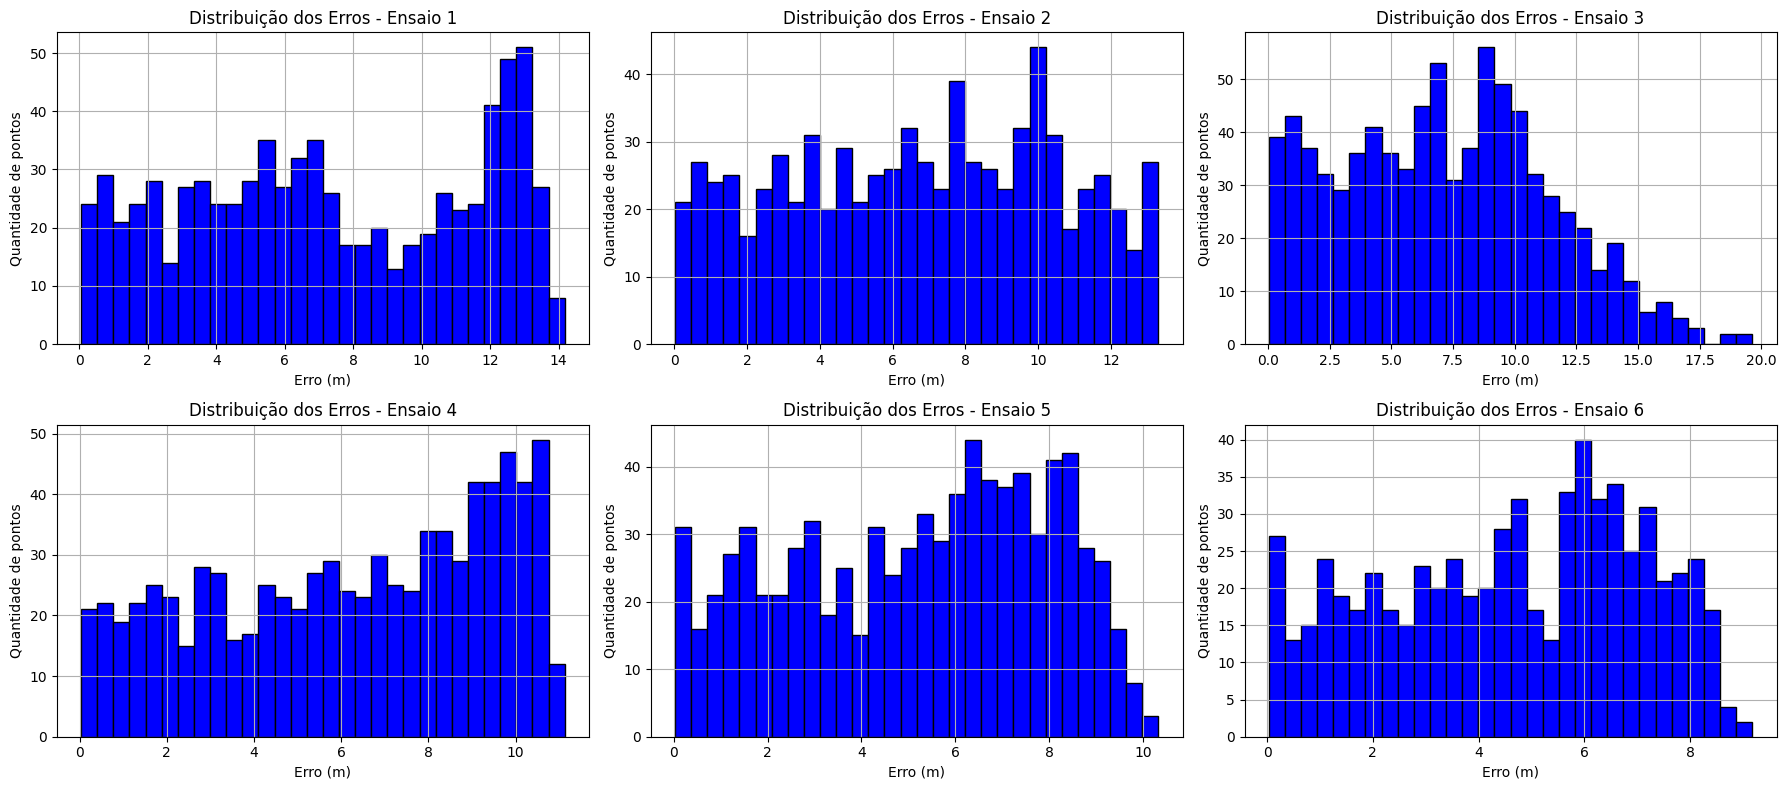

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(18, 8))
axs = axs.flatten()

# Para cada ensaio (lap) presente em laps
for i, lap_name in enumerate(laps.keys()):
    # Seleciona os erros do esp32, celular ou garmin, ajustando conforme a necessidade
    erros = laps[lap_name]['esp32']['erro_analysis']['erros_metros']  # Alterar 'esp32' para 'celular' ou 'garmin' se necessário
    
    # Cria o histograma para cada lap
    axs[i].hist(erros, bins=30, color='blue', edgecolor='black')
    axs[i].set_title(f'Distribuição dos Erros - {labels[i]}')
    axs[i].set_xlabel('Erro (m)')
    axs[i].set_ylabel('Quantidade de pontos')
    axs[i].grid(True)

# Ajusta o layout para não sobrepor os elementos
plt.tight_layout()
plt.show()


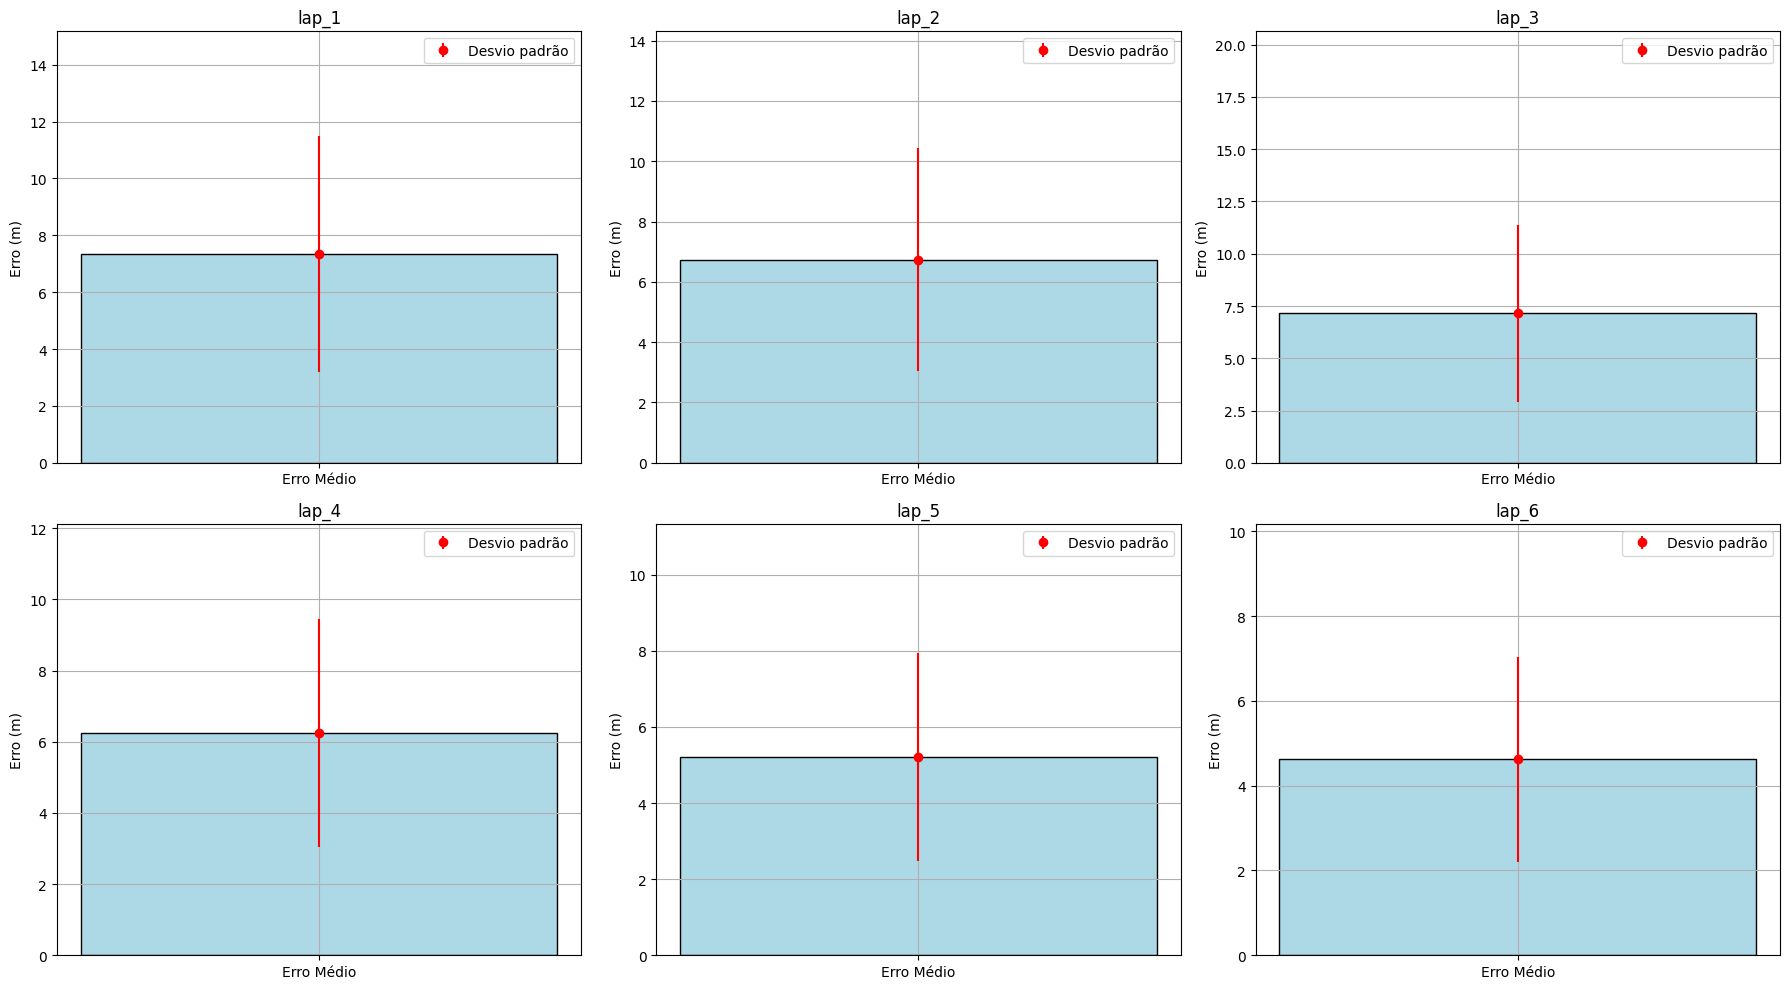

In [69]:
# Lista para extrair os erros médios e desvios diretamente do dicionário laps
laps_names = list(laps.keys())

# Plota
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

for i, lap_name in enumerate(laps_names):
    # Acessa os resultados já calculados e armazenados no dicionário laps[lap_name]['esp32']['erro_analysis']
    media_erro = laps[lap_name]['esp32']['erro_analysis']['media_erro_m']
    desvio_erro = laps[lap_name]['esp32']['erro_analysis']['desvio_erro_m']
    max_erro = laps[lap_name]['esp32']['erro_analysis']['max_erro_m']
    min_erro = laps[lap_name]['esp32']['erro_analysis']['min_erro_m']

    # Cria uma barra para o erro médio
    axs[i].bar(['Erro Médio'], [media_erro], color='lightblue', edgecolor='black')

    # Adiciona a barra de erro representando o desvio padrão
    axs[i].errorbar('Erro Médio', media_erro, yerr=desvio_erro, fmt='o', color='red', label='Desvio padrão')

    # Ajusta o limite superior do gráfico para dar espaço ao erro máximo
    axs[i].set_ylim(0, max_erro + 1)
    axs[i].set_title(f"{lap_name}")
    axs[i].set_ylabel("Erro (m)")

    # Adiciona a legenda e a grade
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()


### Erro Mínima Distância + Ângulo

Esse erro parece mais correto pois se eu tiver um deslocamento do meu circulo e ele fizer a intersecção na referência, a intersecção será o menor valor. O correto seria tentar pelo grau que aquele ponto se encontra baseado no seu ponto central que forma o circulo para os dados

In [71]:
def calcular_angulo(ponto, centro):
    delta_x = ponto[1] - centro[1]  # longitude
    delta_y = ponto[0] - centro[0]  # latitude
    angulo_rad = np.arctan2(delta_y, delta_x)
    angulo_deg = np.degrees(angulo_rad) % 360
    return angulo_deg

# Faz uma cópia da referência e calcula ângulo dela uma única vez
ref = df_pivot.copy()
centro = (pivot_lat, pivot_long)
ref['angulo'] = ref.apply(
    lambda row: calcular_angulo((row['latitude'], row['longitude']), centro),
    axis=1
)

# Loop sobre cada volta
for lap_name in laps.keys():
    esp = laps[lap_name]["esp32"].get("dataframe")
    if esp is None or esp.empty:
        continue

    erros_metros = []
    for _, ponto in esp.iterrows():
        ponto_ensaio = (ponto['latitude'], ponto['longitude'])
        angulo_ensaio = calcular_angulo(ponto_ensaio, centro)

        # índice do ponto de referência com ângulo mais próximo
        idx_ref = (ref['angulo'] - angulo_ensaio).abs().idxmin()
        ponto_ref = (ref.loc[idx_ref, 'latitude'], ref.loc[idx_ref, 'longitude'])

        # adiciona distância geodésica
        erros_metros.append(geodesic(ponto_ensaio, ponto_ref).meters)

    # calcula estatísticas
    media_erro = np.mean(erros_metros)
    desvio_erro = np.std(erros_metros)
    max_erro   = np.max(erros_metros)
    min_erro   = np.min(erros_metros)

    # armazena dentro de cada volta
    laps[lap_name]["esp32"]["erro_analysis_angle"] = {
        'media_erro_m':   media_erro,
        'desvio_erro_m':  desvio_erro,
        'max_erro_m':     max_erro,
        'min_erro_m':     min_erro,
        'qtd_pontos':     len(erros_metros),
        'erros_metros':   erros_metros
    }

# Exibe o resumo
for lap_name in laps.keys():
    ana = laps[lap_name]["esp32"].get("erro_analysis_angle")
    if not ana:
        continue
    print(f"\n{lap_name} (ESP32, erro por ângulo):")
    print(f"  ➔ Erro médio: {ana['media_erro_m']:.2f} m")
    print(f"  ➔ Desvio padrão: {ana['desvio_erro_m']:.2f} m")
    print(f"  ➔ Erro máximo: {ana['max_erro_m']:.2f} m")
    print(f"  ➔ Erro mínimo: {ana['min_erro_m']:.2f} m")
    print(f"  ➔ Pontos avaliados: {ana['qtd_pontos']}")



lap_1 (ESP32, erro por ângulo):
  ➔ Erro médio: 7.33 m
  ➔ Desvio padrão: 4.15 m
  ➔ Erro máximo: 14.18 m
  ➔ Erro mínimo: 0.05 m
  ➔ Pontos avaliados: 778

lap_2 (ESP32, erro por ângulo):
  ➔ Erro médio: 6.74 m
  ➔ Desvio padrão: 3.69 m
  ➔ Erro máximo: 13.31 m
  ➔ Erro mínimo: 0.02 m
  ➔ Pontos avaliados: 767

lap_3 (ESP32, erro por ângulo):
  ➔ Erro médio: 7.14 m
  ➔ Desvio padrão: 4.22 m
  ➔ Erro máximo: 19.64 m
  ➔ Erro mínimo: 0.02 m
  ➔ Pontos avaliados: 819

lap_4 (ESP32, erro por ângulo):
  ➔ Erro médio: 6.25 m
  ➔ Desvio padrão: 3.21 m
  ➔ Erro máximo: 11.12 m
  ➔ Erro mínimo: 0.03 m
  ➔ Pontos avaliados: 817

lap_5 (ESP32, erro por ângulo):
  ➔ Erro médio: 5.22 m
  ➔ Desvio padrão: 2.73 m
  ➔ Erro máximo: 10.34 m
  ➔ Erro mínimo: 0.02 m
  ➔ Pontos avaliados: 819

lap_6 (ESP32, erro por ângulo):
  ➔ Erro médio: 4.62 m
  ➔ Desvio padrão: 2.41 m
  ➔ Erro máximo: 9.18 m
  ➔ Erro mínimo: 0.03 m
  ➔ Pontos avaliados: 650


## Celular

In [72]:
df_celular_250_1 = pd.read_excel('Dados/celular_volta_4.xlsx') # 25Hz inversor = 2,5ms - lap_1
df_celular_250_2 = pd.read_excel('Dados/celular_volta_5.xlsx') # 25Hz inversor = 2,5ms - lap_2
df_celular_250_3 = pd.read_excel('Dados/celular_volta_6.xlsx') # 25Hz inversor = 2,5ms - lap_3

df_celular_125_1 = pd.read_excel('Dados/celular_volta_7.xlsx') # 12,5Hz inversor = 2,5ms - lap_4
df_celular_125_2 = pd.read_excel('Dados/celular_volta_8.xlsx') # 12,5Hz inversor = 2,5ms - lap_5
df_celular_125_3 = pd.read_excel('Dados/celular_volta_2.xlsx') # 12,5Hz inversor = 2,5ms - lap_6


laps["lap_1"]["celular"]["dataframe"] = df_celular_250_1
laps["lap_2"]["celular"]["dataframe"] = df_celular_250_2
laps["lap_3"]["celular"]["dataframe"] = df_celular_250_3
laps["lap_4"]["celular"]["dataframe"] = df_celular_125_1
laps["lap_5"]["celular"]["dataframe"] = df_celular_125_2
laps["lap_6"]["celular"]["dataframe"] = df_celular_125_3

laps["lap_6"]["celular"]["dataframe"]

,Track Name,Time,Geometry,Lat,Lon,X,Y,Elevation,Ortho Height,Instrument Ht,Fix ID,Speed,Bearing,Horizontal Accuracy,Vertical Accuracy,PDOP,HDOP,VDOP,Satellites in View,Satellites in Use
0,volta 4,04/23/2025 15:49:15.000 GMT-03:00,"POINT Z (-47,628639033 -22,713400617 542,300)",-22713400617,-47628639033,229980751.0,7.485813e+09,542.3,0,0,1,0.000,-1.0,3.79,2.5,0,0,0,26,21
1,volta 4,04/23/2025 15:49:20.000 GMT-03:00,"POINT Z (-47,628639333 -22,713399817 543,100)",-22713399817,-47628639333,229980719.0,7.485813e+09,543.1,0,0,1,0.000,-1.0,3.79,2.5,0,0,0,29,23
2,volta 4,04/23/2025 15:49:25.000 GMT-03:00,"POINT Z (-47,628639050 -22,713400100 543,400)",-227134001,-4762863905,229980748.0,7.485813e+09,543.4,0,0,1,0.000,-1.0,3.79,2.5,0,0,0,30,24
3,volta 4,04/23/2025 15:49:30.000 GMT-03:00,"POINT Z (-47,628639250 -22,713399983 543,500)",-22713399983,-4762863925,229980727.0,7.485813e+09,543.5,0,0,1,0.000,-1.0,3.79,2.5,0,0,0,31,24
4,volta 4,04/23/2025 15:49:35.000 GMT-03:00,"POINT Z (-47,628638933 -22,713400583 543,400)",-22713400583,-47628638933,229980761.0,7.485813e+06,543.4,0,0,1,0.000,-1.0,3.79,2.5,0,0,0,30,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872,volta 4,04/23/2025 17:01:55.000 GMT-03:00,"POINT Z (-47,628634133 -22,713472800 545,000)",-227134728,-47628634133,229981396.0,7.485805e+09,545.0,0,0,1,0.772,328.4,3.79,2.5,0,0,0,30,25
873,volta 4,04/23/2025 17:02:00.000 GMT-03:00,"POINT Z (-47,628645533 -22,713441117 545,600)",-22713441117,-47628645533,229980162.0,7.485809e+09,545.6,0,0,1,0.720,329.2,3.79,2.5,0,0,0,29,25
874,volta 4,04/23/2025 17:02:05.000 GMT-03:00,"POINT Z (-47,628642033 -22,713404833 546,100)",-22713404833,-47628642033,229980451.0,7.485813e+09,546.1,0,0,1,0.772,358.6,3.79,2.5,0,0,0,30,24
875,volta 4,04/23/2025 17:02:10.000 GMT-03:00,"POINT Z (-47,628633383 -22,713388983 546,100)",-22713388983,-47628633383,229981309.0,7.485815e+09,546.1,0,0,1,0.000,-1.0,3.79,2.5,0,0,0,29,25


In [79]:
# Função para limpar e formatar as coordenadas, pois o celular fornece a string meio estranha, como: -22485693359 ao invés de -22.485693359
def clean_coord(val):
    try:
        if pd.isna(val):
            return None
        val = str(val).replace('.', '')  # Remove todos os pontos
        if len(val) < 3:
            return None  # Muito curto pra ser coordenada válida
        return float(val[:3] + '.' + val[3:])  # Ex: "22713333" → 22.713333
    except Exception:
        return None

# Percorrendo as chaves do dicionário, cortando os dados capturados fora do range de lap_start e lap_end e manipulando a string para
# ela fica no padrão de -22.12412 pois atualmente não tem um ponto dividindo
for lap_name, lap_data in laps.items():
    
    df_cel = lap_data.get("celular", {}).get("dataframe")
    if df_cel is None or df_cel.empty:
        continue

    # Converte a coluna 'Time' para datetime e localiza no fuso de SP
    df_cel['Time'] = pd.to_datetime(df_cel['Time'])

    # Cria timestamps de início e fim já com fuso e tirando os 5 primeiros e os 5 últimos minutos
    start_time = pd.Timestamp(lap_data["lap_start"]).tz_localize("America/Sao_Paulo") + pd.Timedelta(minutes=5)
    end_time   = pd.Timestamp(lap_data["lap_end"]).tz_localize("America/Sao_Paulo") - pd.Timedelta(minutes=5)


    # Filtra pelo intervalo da volta
    df_cel = df_cel[(df_cel['Time'] >= start_time) & (df_cel['Time'] <= end_time)]

    # Ordena e reseta índice
    df_cel = df_cel.sort_values('Time').reset_index(drop=True)

    # Limpa as coordenadas brutas
    df_cel['Lat'] = df_cel['Lat'].apply(clean_coord)
    df_cel['Lon'] = df_cel['Lon'].apply(clean_coord)

    # Reatribui o DataFrame tratado ao dicionário
    laps[lap_name]["celular"]["dataframe"] = df_cel

In [80]:
laps["lap_6"]["celular"]["dataframe"]

,Track Name,Time,Geometry,Lat,Lon,X,Y,Elevation,Ortho Height,Instrument Ht,Fix ID,Speed,Bearing,Horizontal Accuracy,Vertical Accuracy,PDOP,HDOP,VDOP,Satellites in View,Satellites in Use
0,volta 4,2025-04-23 15:56:00-03:00,"POINT Z (-47,628444167 -22,713450733 542,500)",-22.713451,-47.628444,230000876.0,7.485808e+06,542.5,0,0,1,1903.0,197.8,3.79,2.5,0,0,0,31,25
1,volta 4,2025-04-23 15:56:05-03:00,"POINT Z (-47,628518667 -22,713506317 542,700)",-22.713506,-47.628519,229993329.0,7.485802e+09,542.7,0,0,1,1903.0,250.4,3.79,2.5,0,0,0,31,26
2,volta 4,2025-04-23 15:56:10-03:00,"POINT Z (-47,628611833 -22,713485017 542,900)",-22.713485,-47.628612,229983712.0,7.485804e+09,542.9,0,0,1,1955.0,303.6,3.79,2.5,0,0,0,31,26
3,volta 4,2025-04-23 15:56:15-03:00,"POINT Z (-47,628649450 -22,713402950 543,400)",-22.713403,-47.628649,229979685.0,7.485813e+09,543.4,0,0,1,1903.0,356.7,3.79,2.5,0,0,0,31,27
4,volta 4,2025-04-23 15:56:20-03:00,"POINT Z (-47,628600567 -22,713325867 543,900)",-22.713326,-47.628601,229984557.0,7.485822e+09,543.9,0,0,1,1903.0,49.4,3.79,2.5,0,0,0,31,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,volta 4,2025-04-23 16:55:40-03:00,"POINT Z (-47,628526183 -22,713518667 543,300)",-22.713519,-47.628526,229992581.0,7.485800e+09,543.3,0,0,1,1955.0,251.0,3.79,2.5,0,0,0,29,23
717,volta 4,2025-04-23 16:55:45-03:00,"POINT Z (-47,628617517 -22,713495867 543,200)",-22.713496,-47.628618,229983149.0,7.485803e+09,543.2,0,0,1,1903.0,303.8,3.79,2.5,0,0,0,28,22
718,volta 4,2025-04-23 16:55:50-03:00,"POINT Z (-47,628655833 -22,713415917 543,700)",-22.713416,-47.628656,229979054.0,7.485812e+09,543.7,0,0,1,1903.0,356.7,3.79,2.5,0,0,0,29,24
719,volta 4,2025-04-23 16:55:55-03:00,"POINT Z (-47,628606050 -22,713338617 543,900)",-22.713339,-47.628606,229984019.0,7.485820e+09,543.9,0,0,1,1903.0,49.6,3.79,2.5,0,0,0,30,23


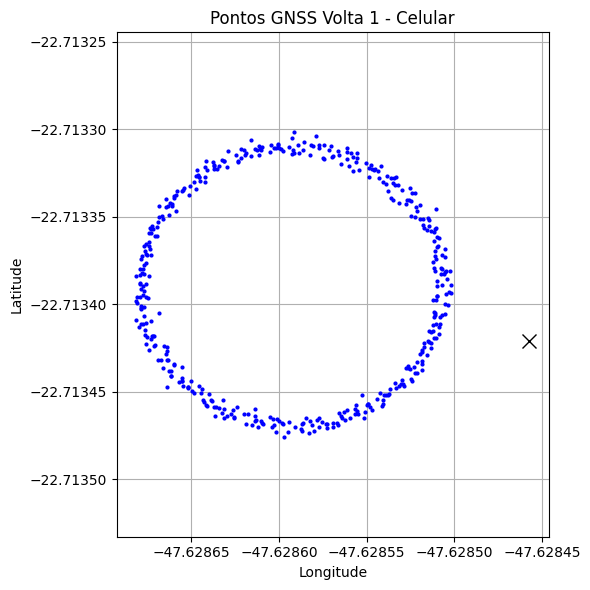

In [85]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(laps['lap_1']["celular"]["dataframe"]["Lon"], laps['lap_1']["celular"]["dataframe"]["Lat"], marker='o', linestyle="", markersize=2, color='blue')
ax.plot(pivot_long, pivot_lat, marker='x', color='black', markersize=10, label='Ponto de Pivô')
ax.set_title("Pontos GNSS Volta 1 - Celular")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
ax.axis("equal")  # Mantém proporção correta
ax.ticklabel_format(useOffset=False)  # <--- ESSA LINHA REMOVE O OFFSET

plt.tight_layout()
plt.show()

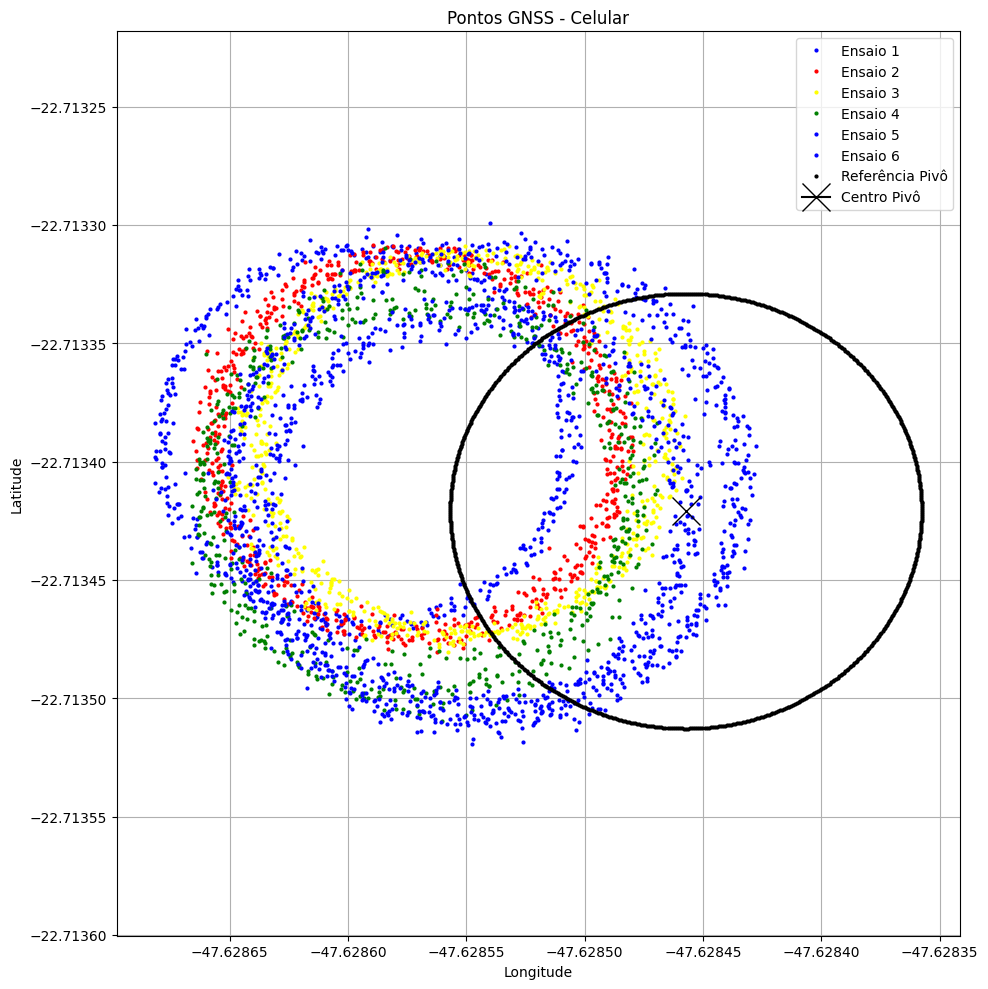

In [86]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot( laps['lap_1']["celular"]["dataframe"]["Lon"], laps['lap_1']["celular"]["dataframe"]["Lat"], marker='o', linestyle="", markersize=2, color='blue', label="Ensaio 1")
ax.plot( laps['lap_2']["celular"]["dataframe"]["Lon"], laps['lap_2']["celular"]["dataframe"]["Lat"], marker='o', linestyle="", markersize=2, color='red', label="Ensaio 2")
ax.plot( laps['lap_3']["celular"]["dataframe"]["Lon"], laps['lap_3']["celular"]["dataframe"]["Lat"], marker='o', linestyle="", markersize=2, color='yellow', label="Ensaio 3")
ax.plot( laps['lap_4']["celular"]["dataframe"]["Lon"], laps['lap_4']["celular"]["dataframe"]["Lat"], marker='o', linestyle="", markersize=2, color='green', label="Ensaio 4")
ax.plot( laps['lap_5']["celular"]["dataframe"]["Lon"], laps['lap_5']["celular"]["dataframe"]["Lat"], marker='o', linestyle="", markersize=2, color='blue', label="Ensaio 5")
ax.plot( laps['lap_6']["celular"]["dataframe"]["Lon"], laps['lap_6']["celular"]["dataframe"]["Lat"], marker='o', linestyle="", markersize=2, color='blue', label="Ensaio 6")
ax.plot(df_pivot["longitude"], df_pivot["latitude"], marker='o', linestyle="", markersize=2, color='black', label="Referência Pivô")
ax.plot(pivot_long, pivot_lat, marker='x', color='black', markersize=20, label="Centro Pivô")

ax.legend()

ax.set_title("Pontos GNSS - Celular")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
ax.axis("equal")  # Mantém proporção correta
ax.ticklabel_format(useOffset=False)  # <--- ESSA LINHA REMOVE O OFFSET

plt.tight_layout()
plt.show()

In [87]:
# Primeiro, criar o mapa centralizado no seu pivô
map_celular = folium.Map(location=[pivot_lat, pivot_long], zoom_start=17, tiles="OpenStreetMap")

# Definindo as voltas, cores e nomes
laps_to_plot = ['lap_1', 'lap_2', 'lap_3', 'lap_4', 'lap_5', 'lap_6']
colors = ['blue', 'red', 'yellow', 'green', 'purple', 'orange']
labels = ['Ensaio 1', 'Ensaio 2', 'Ensaio 3', 'Ensaio 4', 'Ensaio 5', 'Ensaio 6']

# Adiciona os pontos de cada volta
for lap_name, color, label in zip(laps_to_plot, colors, labels):
    if "celular" in laps[lap_name] and "dataframe" in laps[lap_name]["celular"]:
        df = laps[lap_name]["celular"]["dataframe"]
        for _, row in df.iterrows():
            folium.CircleMarker(
                location=[row['Lat'], row['Lon']],
                radius=2,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.7,
                popup=f"{label}"
            ).add_to(map_celular)

# Adiciona os pontos de referência do pivô
for _, row in df_pivot.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.7,
        popup="Referência Pivô"
    ).add_to(map_celular)

# Adiciona o centro do pivô
folium.Marker(
    location=[pivot_lat, pivot_long],
    icon=folium.Icon(color='black', icon='star'),
    popup="Centro Pivô"
).add_to(map_celular)

# Salva o mapa
map_celular.save("mapa_celular.html")


### Erro Mínima Distância Geodésica

Esse método de cálculo de erro analisa a menor distância geodésica de cada ponto para o ponto mais próximo da referência do pivô

In [94]:
for lap_name in laps.keys():
    # Verifica se os dados do celular estão disponíveis
    if "celular" in laps[lap_name] and "dataframe" in laps[lap_name]["celular"]:
        lap = laps[lap_name]["celular"]["dataframe"]

        erros_metros = []

        for _, ponto_lap in lap.iterrows():
            ponto_ensaio = (ponto_lap['Lat'], ponto_lap['Lon'])

            # Calcula a distância para todos os pontos de referência
            distancias = [
                geodesic(ponto_ensaio, (row['latitude'], row['longitude'])).meters
                for _, row in df_pivot.iterrows()
            ]

            # Pega a menor distância
            erro_minimo = min(distancias)
            erros_metros.append(erro_minimo)

        # Calcula estatísticas
        media_erro = np.mean(erros_metros)
        desvio_erro = np.std(erros_metros)
        max_erro = np.max(erros_metros)
        min_erro = np.min(erros_metros)
        dois_sigma = 2 * desvio_erro

        # Salva os resultados na estrutura atual
        laps[lap_name]["celular"]["erro_analysis"] = {
            'media_erro_m': media_erro,
            'desvio_erro_m': desvio_erro,
            '2sigma_m': dois_sigma,
            'max_erro_m': max_erro,
            'min_erro_m': min_erro,
            'qtd_pontos': len(erros_metros),
            'erros_metros': erros_metros
        }

# Mostra resumo geral
for lap_name in laps.keys():
    if "celular" in laps[lap_name] and "erro_analysis" in laps[lap_name]["celular"]:
        res = laps[lap_name]["celular"]["erro_analysis"]
        print(f"\n{lap_name}:")
        print(f"  ➔ Erro médio: {res['media_erro_m']:.2f} m")
        print(f"  ➔ Desvio padrão: {res['desvio_erro_m']:.2f} m")
        print(f"  ➔ 2σ: {res['2sigma_m']:.2f} m")
        print(f"  ➔ Erro máximo: {res['max_erro_m']:.2f} m")
        print(f"  ➔ Erro mínimo: {res['min_erro_m']:.2f} m")
        print(f"  ➔ Quantidade de pontos: {res['qtd_pontos']}")



lap_1:
  ➔ Erro médio: 6.96 m
  ➔ Desvio padrão: 4.23 m
  ➔ 2σ: 8.45 m
  ➔ Erro máximo: 13.18 m
  ➔ Erro mínimo: 0.02 m
  ➔ Quantidade de pontos: 432

lap_2:
  ➔ Erro médio: 6.10 m
  ➔ Desvio padrão: 3.31 m
  ➔ 2σ: 6.61 m
  ➔ Erro máximo: 11.88 m
  ➔ Erro mínimo: 0.03 m
  ➔ Quantidade de pontos: 720

lap_3:
  ➔ Erro médio: 5.47 m
  ➔ Desvio padrão: 2.80 m
  ➔ 2σ: 5.59 m
  ➔ Erro máximo: 9.89 m
  ➔ Erro mínimo: 0.04 m
  ➔ Quantidade de pontos: 720

lap_4:
  ➔ Erro médio: 6.13 m
  ➔ Desvio padrão: 3.24 m
  ➔ 2σ: 6.47 m
  ➔ Erro máximo: 11.86 m
  ➔ Erro mínimo: 0.02 m
  ➔ Quantidade de pontos: 640

lap_5:
  ➔ Erro médio: 5.12 m
  ➔ Desvio padrão: 2.64 m
  ➔ 2σ: 5.28 m
  ➔ Erro máximo: 9.99 m
  ➔ Erro mínimo: 0.03 m
  ➔ Quantidade de pontos: 606

lap_6:
  ➔ Erro médio: 5.63 m
  ➔ Desvio padrão: 2.92 m
  ➔ 2σ: 5.84 m
  ➔ Erro máximo: 10.57 m
  ➔ Erro mínimo: 0.02 m
  ➔ Quantidade de pontos: 721


In [96]:
# Código apenas para estruturar as informações dos erros e mostrar de maneira organizada
dados_erro = []

# Define os rótulos das voltas, por exemplo:
labels = ['Ensaio 1', 'Ensaio 2', 'Ensaio 3', 'Ensaio 4', 'Ensaio 5', 'Ensaio 6']

for i, lap_name in enumerate(laps.keys()):
    # Acessa as métricas de erro do celular
    erro_analysis = laps[lap_name]['celular']['erro_analysis']
    
    dados_erro.append({
        'Lap': labels[i],
        'Erro Médio (m)': erro_analysis['media_erro_m'],
        'Desvio Padrão (m)': erro_analysis['desvio_erro_m'],
        '2σ (m)': erro_analysis['2sigma_m'],
        'Erro Máximo (m)': erro_analysis['max_erro_m'],
        'Erro Mínimo (m)': erro_analysis['min_erro_m'],
        'Quantidade de Pontos': erro_analysis['qtd_pontos']
    })

# Cria o DataFrame
df_erro_celular = pd.DataFrame(dados_erro)

df_erro_celular

,Lap,Erro Médio (m),Desvio Padrão (m),2σ (m),Erro Máximo (m),Erro Mínimo (m),Quantidade de Pontos
0,Ensaio 1,6.957538,4.225969,8.451939,13.178238,0.016814,432
1,Ensaio 2,6.103698,3.306135,6.612270,11.876654,0.034437,720
2,Ensaio 3,5.466298,2.795924,5.591848,9.891086,0.038863,720
3,Ensaio 4,6.125095,3.236735,6.473470,11.857246,0.021664,640
4,Ensaio 5,5.120528,2.641416,5.282833,9.993496,0.027004,606
5,Ensaio 6,5.627024,2.917712,5.835424,10.573419,0.015960,721


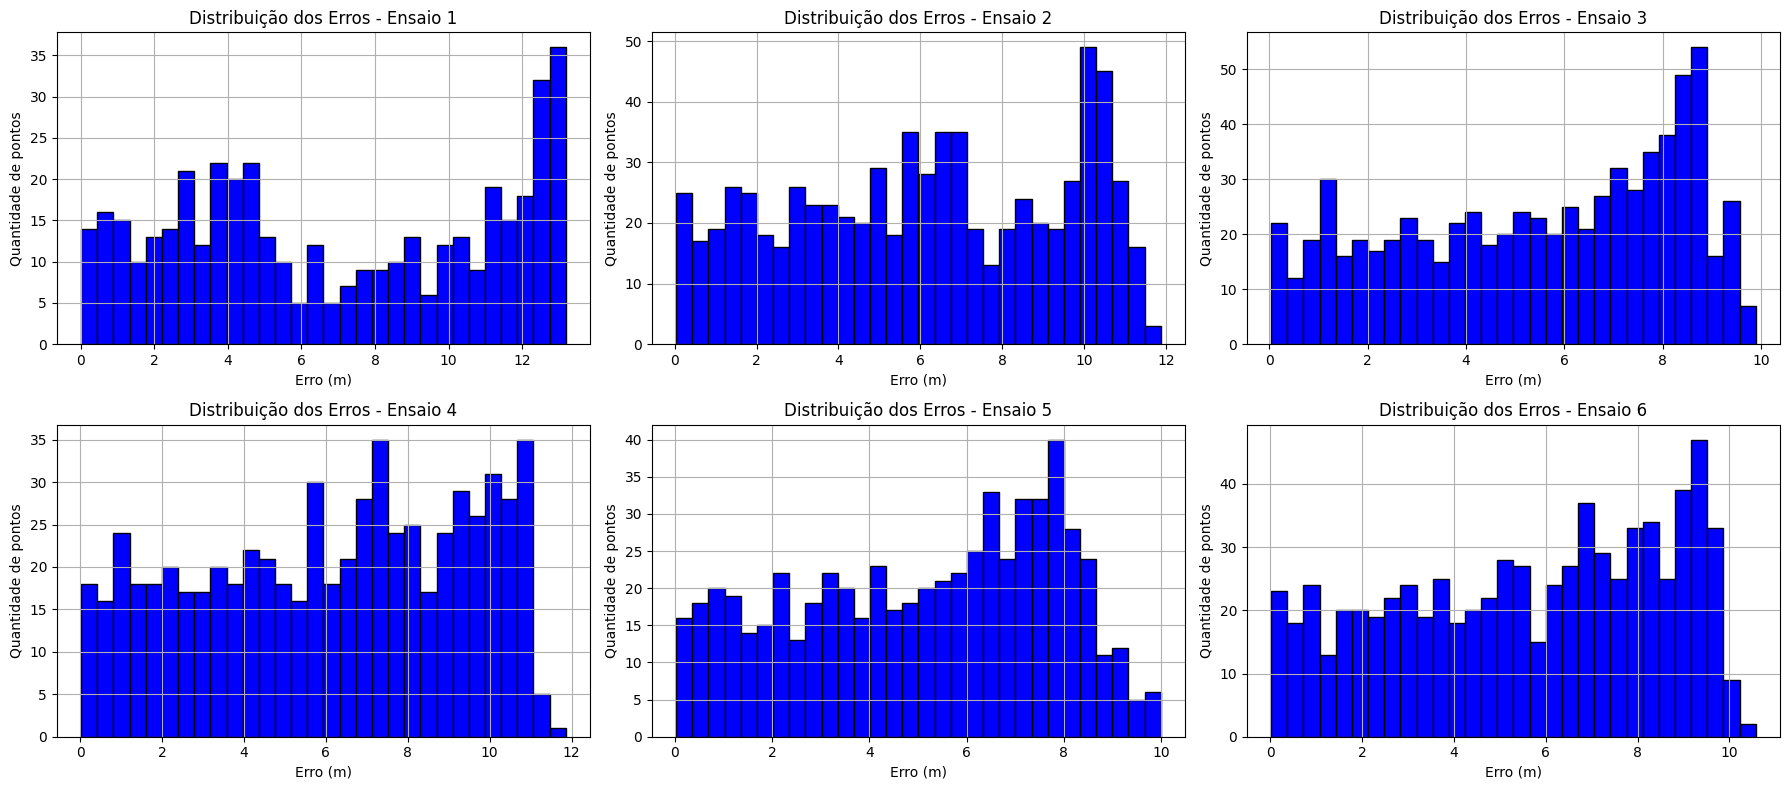

In [98]:
# Vamos criar uma figura grande para 6 subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 8))
axs = axs.flatten()

# Para cada ensaio (lap) presente em laps
for i, lap_name in enumerate(laps.keys()):
    # Garante que existe análise de erro para celular
    if "celular" in laps[lap_name] and "erro_analysis" in laps[lap_name]["celular"]:
        erros = laps[lap_name]['celular']['erro_analysis']['erros_metros']  # Erros individuais do celular

        # Cria o histograma para cada lap
        axs[i].hist(erros, bins=30, color='blue', edgecolor='black')
        axs[i].set_title(f'Distribuição dos Erros - {labels[i]}')
        axs[i].set_xlabel('Erro (m)')
        axs[i].set_ylabel('Quantidade de pontos')
        axs[i].grid(True)

# Ajusta o layout para não sobrepor os elementos
plt.tight_layout()
plt.show()



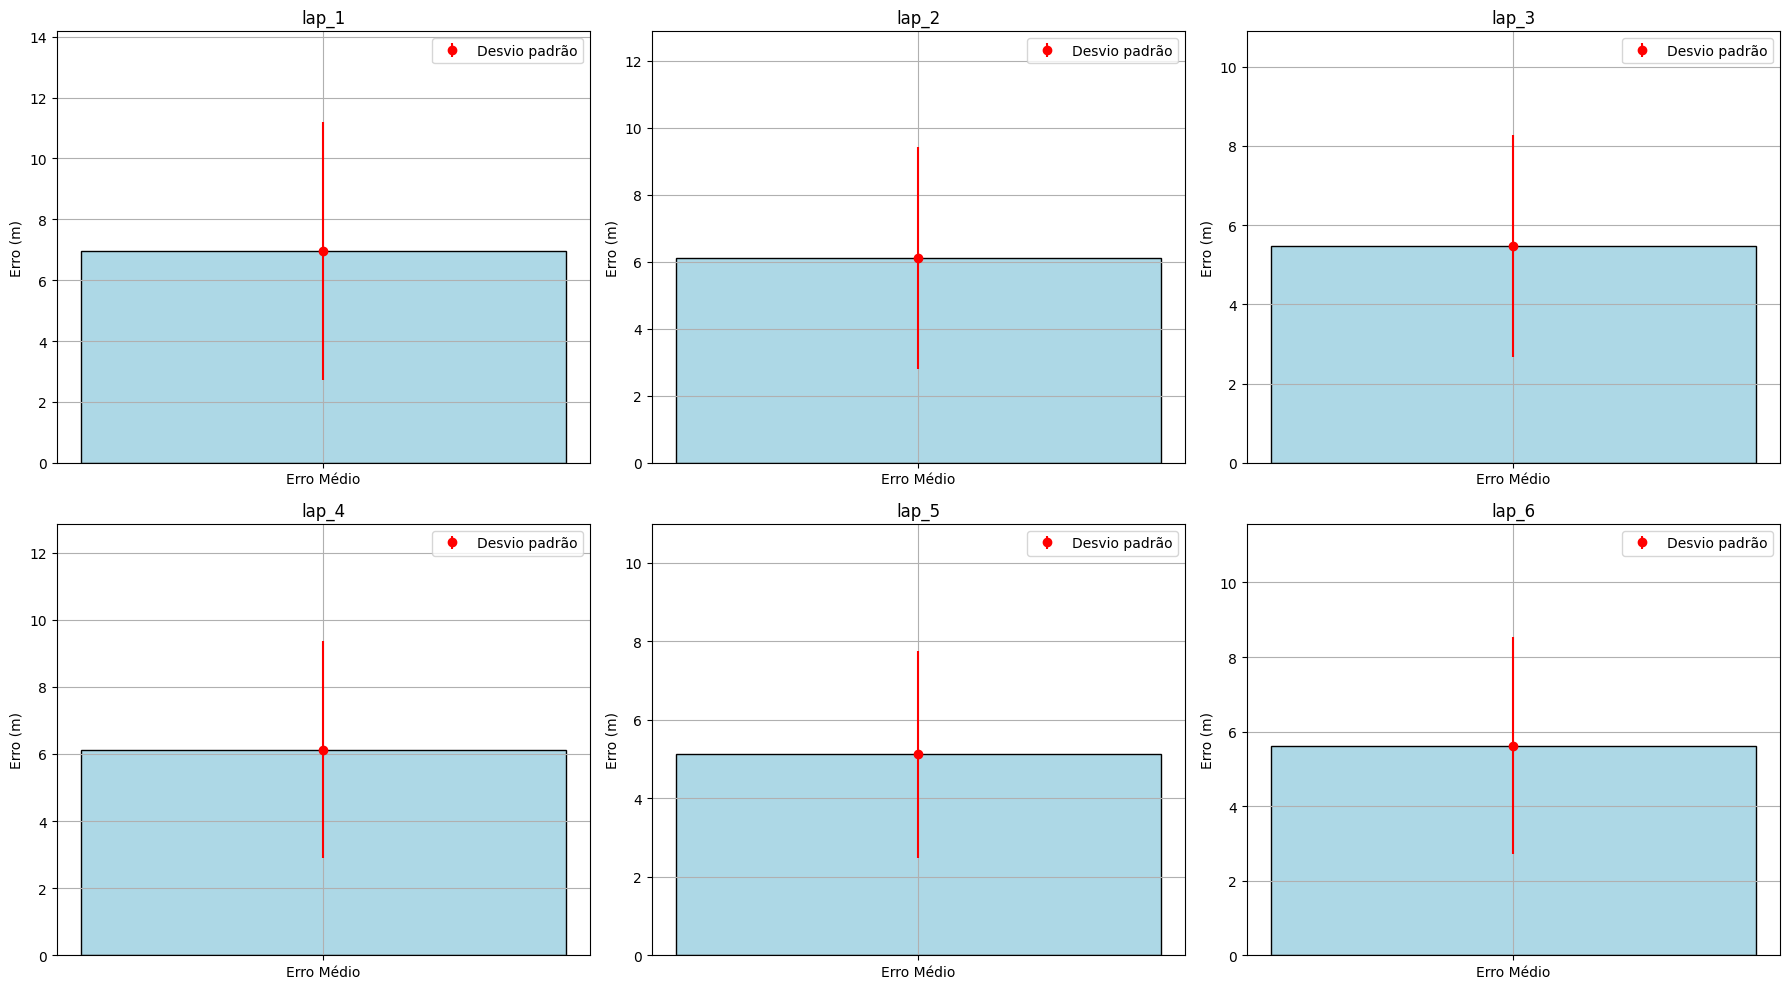

In [99]:
# Lista para extrair os erros médios e desvios diretamente do dicionário laps
laps_names = list(laps.keys())

# Plota
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

for i, lap_name in enumerate(laps_names):
    if "celular" in laps[lap_name] and "erro_analysis" in laps[lap_name]["celular"]:
        erro_analysis = laps[lap_name]['celular']['erro_analysis']

        media_erro = erro_analysis['media_erro_m']
        desvio_erro = erro_analysis['desvio_erro_m']
        max_erro = erro_analysis['max_erro_m']

        # Cria uma barra para o erro médio
        axs[i].bar(['Erro Médio'], [media_erro], color='lightblue', edgecolor='black')

        # Adiciona a barra de erro representando o desvio padrão
        axs[i].errorbar('Erro Médio', media_erro, yerr=desvio_erro, fmt='o', color='red', label='Desvio padrão')

        # Ajusta o limite superior do gráfico para dar espaço ao erro máximo
        axs[i].set_ylim(0, max_erro + 1)
        axs[i].set_title(f"{lap_name}")
        axs[i].set_ylabel("Erro (m)")

        # Adiciona a legenda e a grade
        axs[i].legend()
        axs[i].grid(True)

plt.tight_layout()
plt.show()

### Erro Mínima Distância + Ângulo

Esse erro parece mais correto pois se eu tiver um deslocamento do meu circulo e ele fizer a intersecção na referência, a intersecção será o menor valor. O correto seria tentar pelo grau que aquele ponto se encontra baseado no seu ponto central que forma o circulo para os dados

In [100]:
def calcular_angulo(ponto, centro):
    delta_x = ponto[1] - centro[1]  # longitude
    delta_y = ponto[0] - centro[0]  # latitude
    angulo_rad = np.arctan2(delta_y, delta_x)
    angulo_deg = np.degrees(angulo_rad) % 360
    return angulo_deg

# Faz uma cópia da referência e calcula ângulo dela uma única vez
ref = df_pivot.copy()
centro = (pivot_lat, pivot_long)
ref['angulo'] = ref.apply(
    lambda row: calcular_angulo((row['latitude'], row['longitude']), centro),
    axis=1
)

# Loop sobre cada volta
for lap_name in laps.keys():
    celular = laps[lap_name]["celular"].get("dataframe")
    if celular is None or celular.empty:
        continue

    erros_metros = []
    for _, ponto in celular.iterrows():
        ponto_ensaio = (ponto['Lat'], ponto['Lon'])
        angulo_ensaio = calcular_angulo(ponto_ensaio, centro)

        # índice do ponto de referência com ângulo mais próximo
        idx_ref = (ref['angulo'] - angulo_ensaio).abs().idxmin()
        ponto_ref = (ref.loc[idx_ref, 'latitude'], ref.loc[idx_ref, 'longitude'])

        # adiciona distância geodésica
        erros_metros.append(geodesic(ponto_ensaio, ponto_ref).meters)

    # calcula estatísticas
    media_erro = np.mean(erros_metros)
    desvio_erro = np.std(erros_metros)
    max_erro   = np.max(erros_metros)
    min_erro   = np.min(erros_metros)

    # armazena dentro de cada volta
    laps[lap_name]["celular"]["erro_analysis_angle"] = {
        'media_erro_m':   media_erro,
        'desvio_erro_m':  desvio_erro,
        'max_erro_m':     max_erro,
        'min_erro_m':     min_erro,
        'qtd_pontos':     len(erros_metros),
        'erros_metros':   erros_metros
    }

# Exibe o resumo
for lap_name in laps.keys():
    ana = laps[lap_name]["celular"].get("erro_analysis_angle")
    if not ana:
        continue
    print(f"\n{lap_name} (CELULAR, erro por ângulo):")
    print(f"  ➔ Erro médio: {ana['media_erro_m']:.2f} m")
    print(f"  ➔ Desvio padrão: {ana['desvio_erro_m']:.2f} m")
    print(f"  ➔ Erro máximo: {ana['max_erro_m']:.2f} m")
    print(f"  ➔ Erro mínimo: {ana['min_erro_m']:.2f} m")
    print(f"  ➔ Pontos avaliados: {ana['qtd_pontos']}")




lap_1 (CELULAR, erro por ângulo):
  ➔ Erro médio: 6.96 m
  ➔ Desvio padrão: 4.23 m
  ➔ Erro máximo: 13.18 m
  ➔ Erro mínimo: 0.02 m
  ➔ Pontos avaliados: 432

lap_2 (CELULAR, erro por ângulo):
  ➔ Erro médio: 6.10 m
  ➔ Desvio padrão: 3.31 m
  ➔ Erro máximo: 11.88 m
  ➔ Erro mínimo: 0.03 m
  ➔ Pontos avaliados: 720

lap_3 (CELULAR, erro por ângulo):
  ➔ Erro médio: 5.47 m
  ➔ Desvio padrão: 2.80 m
  ➔ Erro máximo: 9.89 m
  ➔ Erro mínimo: 0.04 m
  ➔ Pontos avaliados: 720

lap_4 (CELULAR, erro por ângulo):
  ➔ Erro médio: 6.13 m
  ➔ Desvio padrão: 3.24 m
  ➔ Erro máximo: 11.86 m
  ➔ Erro mínimo: 0.02 m
  ➔ Pontos avaliados: 640

lap_5 (CELULAR, erro por ângulo):
  ➔ Erro médio: 5.12 m
  ➔ Desvio padrão: 2.64 m
  ➔ Erro máximo: 10.00 m
  ➔ Erro mínimo: 0.03 m
  ➔ Pontos avaliados: 606

lap_6 (CELULAR, erro por ângulo):
  ➔ Erro médio: 5.63 m
  ➔ Desvio padrão: 2.92 m
  ➔ Erro máximo: 10.57 m
  ➔ Erro mínimo: 0.02 m
  ➔ Pontos avaliados: 721


## Garmin

In [133]:
'''
    Para carregar os dados do garmin, foi necessário utilizar uma outra abordagem, tendo em vista que sua saída é em csv, mas a estrutura
    do arquivo está toda bagunçada, sendo necessário remover alguns conteúdos na mão e posteriormente carregar o arquivo pensando em uma divisão
    por tabulação.

    CORREÇÂO: alguns arquivos estavam separados por vírgula, não sei o que aconteceu na hora da exportação dos dados
'''

with open("Dados/garmin_volta_4.csv", "r", encoding="utf-8") as f:
    texto = f.read().replace('"', '')
df_garmin_250_1 = pd.read_csv(io.StringIO(texto), sep="\t", engine="python")

with open("Dados/garmin_volta_5.csv", "r", encoding="utf-8") as f:
    texto = f.read().replace('"', '')
df_garmin_250_2 = pd.read_csv(io.StringIO(texto), sep="\t", engine="python")

with open("Dados/garmin_volta_6.csv", "r", encoding="utf-8") as f:
    texto = f.read().replace('"', '')
df_garmin_250_3 = pd.read_csv(io.StringIO(texto), sep=",", engine="python")

with open("Dados/garmin_volta_7.csv", "r", encoding="utf-8") as f:
    texto = f.read().replace('"', '')
df_garmin_125_1 = pd.read_csv(io.StringIO(texto), sep=",", engine="python")

with open("Dados/garmin_volta_8.csv", "r", encoding="utf-8") as f:
    texto = f.read().replace('"', '')
df_garmin_125_2 = pd.read_csv(io.StringIO(texto), sep="\t", engine="python")


with open("Dados/garmin_volta_2.csv", "r", encoding="utf-8") as f:
    texto = f.read().replace('"', '')
df_garmin_125_3 = pd.read_csv(io.StringIO(texto), sep="\t", engine="python")



laps["lap_1"]["garmin"]["dataframe"] = df_garmin_250_1
laps["lap_2"]["garmin"]["dataframe"] = df_garmin_250_2
laps["lap_3"]["garmin"]["dataframe"] = df_garmin_250_3
laps["lap_4"]["garmin"]["dataframe"] = df_garmin_125_1
laps["lap_5"]["garmin"]["dataframe"] = df_garmin_125_2
laps["lap_6"]["garmin"]["dataframe"] = df_garmin_125_3

print(laps["lap_1"]["garmin"]["dataframe"].shape)
print(laps["lap_2"]["garmin"]["dataframe"].shape)
print(laps["lap_3"]["garmin"]["dataframe"].shape)
print(laps["lap_4"]["garmin"]["dataframe"].shape)
print(laps["lap_5"]["garmin"]["dataframe"].shape)
print(laps["lap_6"]["garmin"]["dataframe"].shape)


(1094, 30)
(1007, 30)
(1083, 27)
(1126, 27)
(860, 26)
(1396, 30)


In [135]:
laps["lap_6"]["garmin"]["dataframe"]

,ID,trksegID,lat,lon,ele,time,magvar,geoidheight,name,cmt,...,dgpsid,Temperature,Depth,wtemp,hr,cad,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29
0,1,1.0,-22.713.475.339.114.600,-47.628.267.528.489.200,627.397.705.078.125,2025-04-23T18:09:54Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1.0,-22.713.442.984.968.400,-47.628.420.330.584.000,58.702.197.265.625,2025-04-23T18:09:59Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1.0,-22.713.390.681.892.600,-47.628.602.385.520.900,555.779.296.875,2025-04-23T18:10:04Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1.0,-22.713.394.621.387.100,-47.628.595.931.455.400,55.481.787.109.375,2025-04-23T18:10:09Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1.0,-22.713.398.141.786.400,-47.628.578.580.915.900,556.260.009.765.625,2025-04-23T18:10:14Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391,1392,1.0,-227.133.958.786.726,-47.628.631.554.543.900,54.424.365.234.375,2025-04-23T20:05:50Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1392,1393,1.0,-22.713.396.046.310.600,-47.628.631.722.182.000,54.424.365.234.375,2025-04-23T20:05:55Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1393,1394,1.0,-22.713.396.046.310.600,-47.628.631.973.639.100,54.424.365.234.375,2025-04-23T20:06:00Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1394,1395,1.0,-22.713.396.046.310.600,-47.628.632.057.458.100,54.424.365.234.375,2025-04-23T20:06:03Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:
# Função para limpar e formatar as coordenadas, pois o garmin fornece a string meio estranha, como: -22485693359 ao invés de -22.485693359
# também vou ajustar a hora da minha coluna, pois está 3 horas adiantada
def clean_coord(val):
    try:
        if pd.isna(val):
            return None
        s = str(val).replace('.', '')
        if len(s) < 3:
            return None
        # Ajusta para ter 2 dígitos antes do ponto
        return float(s[:3] + '.' + s[3:])
    except Exception:
        return None

for lap_name, lap_data in laps.items():
    df_gar = lap_data.get("garmin", {}).get("dataframe")
    if df_gar is None or df_gar.empty:
        continue

    # print(df_gar["time"])

    df_gar['time'] = (
        pd.to_datetime(df_gar['time'])
          .dt.tz_convert(None)            # remove timezone se já tiver
          - pd.Timedelta(hours=3)         # Garmin grava +3h
    ).dt.tz_localize("America/Sao_Paulo")  # aplica fuso SP


    start = pd.Timestamp(lap_data['lap_start']).tz_localize("America/Sao_Paulo") + pd.Timedelta(minutes=5)
    end   = pd.Timestamp(lap_data['lap_end'  ]).tz_localize("America/Sao_Paulo") - pd.Timedelta(minutes=5)
    df_gar = df_gar[(df_gar['time'] >= start) & (df_gar['time'] <= end)]

    df_gar = df_gar.sort_values('time').reset_index(drop=True)


    df_gar['lat'] = df_gar['lat'].apply(clean_coord)
    df_gar['lon'] = df_gar['lon'].apply(clean_coord)

    drop_cols = [c for c in df_gar.columns if c.startswith("Unnamed:")]
    df_gar = df_gar.drop(columns=drop_cols)


    laps[lap_name]["garmin"]["dataframe"] = df_gar

In [142]:
laps["lap_6"]["garmin"]["dataframe"]

,ID,trksegID,lat,lon,ele,time,magvar,geoidheight,name,cmt,...,hdop,vdop,pdop,ageofdgpsdata,dgpsid,Temperature,Depth,wtemp,hr,cad
0,554,1.0,-22.713454,-47.628448,5.384.757.080.078.120,2025-04-23 15:56:00-03:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,555,1.0,-22.713507,-47.628517,5.384.757.080.078.120,2025-04-23 15:56:05-03:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,556,1.0,-22.713485,-47.628602,538.956.298.828.125,2025-04-23 15:56:10-03:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,557,1.0,-22.713406,-47.628645,5.384.757.080.078.120,2025-04-23 15:56:15-03:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,558,1.0,-22.713340,-47.628601,538.956.298.828.125,2025-04-23 15:56:20-03:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,1270,1.0,-22.713531,-47.628526,5.432.821.044.921.870,2025-04-23 16:55:40-03:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
717,1271,1.0,-22.713505,-47.628611,5.432.821.044.921.870,2025-04-23 16:55:45-03:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
718,1272,1.0,-22.713422,-47.628646,5.432.821.044.921.870,2025-04-23 16:55:50-03:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
719,1273,1.0,-22.713347,-47.628605,542.801.513.671.875,2025-04-23 16:55:55-03:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


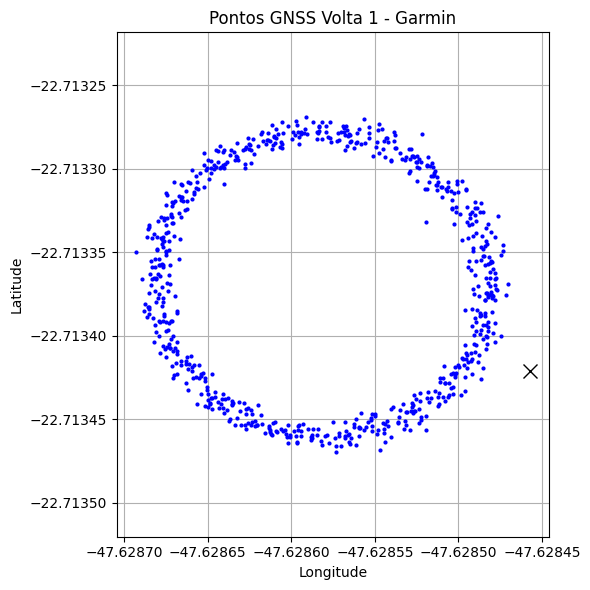

In [143]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(laps['lap_1']["garmin"]["dataframe"]["lon"], laps['lap_1']["garmin"]["dataframe"]["lat"], marker='o', linestyle="", markersize=2, color='blue')
ax.plot(pivot_long, pivot_lat, marker='x', color='black', markersize=10, label='Ponto de Pivô')
ax.set_title("Pontos GNSS Volta 1 - Garmin")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
ax.axis("equal")  # Mantém proporção correta
ax.ticklabel_format(useOffset=False)  # <--- ESSA LINHA REMOVE O OFFSET

plt.tight_layout()
plt.show()

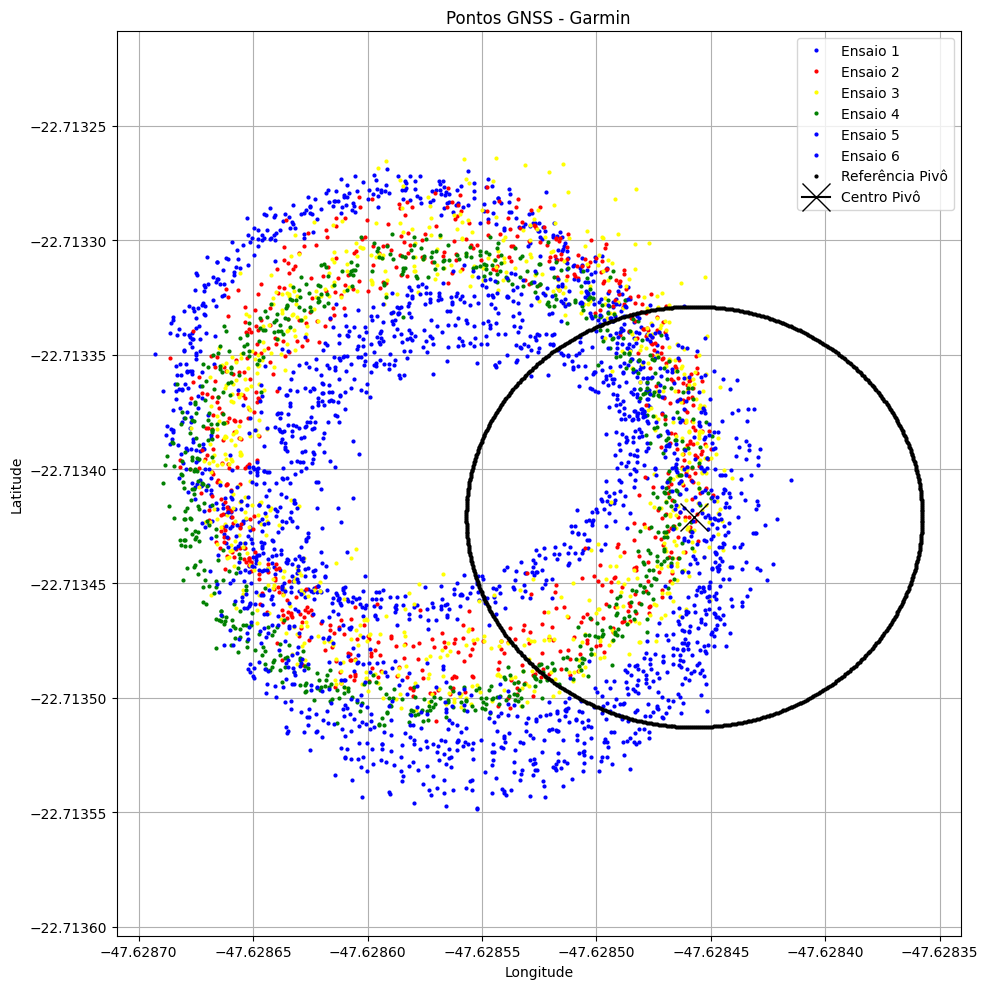

In [149]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot( laps['lap_1']["garmin"]["dataframe"]["lon"], laps['lap_1']["garmin"]["dataframe"]["lat"], marker='o', linestyle="", markersize=2, color='blue', label="Ensaio 1")
ax.plot( laps['lap_2']["garmin"]["dataframe"]["lon"], laps['lap_2']["garmin"]["dataframe"]["lat"], marker='o', linestyle="", markersize=2, color='red', label="Ensaio 2")
ax.plot( laps['lap_3']["garmin"]["dataframe"]["lon"], laps['lap_3']["garmin"]["dataframe"]["lat"], marker='o', linestyle="", markersize=2, color='yellow', label="Ensaio 3")
ax.plot( laps['lap_4']["garmin"]["dataframe"]["lon"], laps['lap_4']["garmin"]["dataframe"]["lat"], marker='o', linestyle="", markersize=2, color='green', label="Ensaio 4")
ax.plot( laps['lap_5']["garmin"]["dataframe"]["lon"], laps['lap_5']["garmin"]["dataframe"]["lat"], marker='o', linestyle="", markersize=2, color='blue', label="Ensaio 5")
ax.plot( laps['lap_6']["garmin"]["dataframe"]["lon"], laps['lap_6']["garmin"]["dataframe"]["lat"], marker='o', linestyle="", markersize=2, color='blue', label="Ensaio 6")
ax.plot(df_pivot["longitude"], df_pivot["latitude"], marker='o', linestyle="", markersize=2, color='black', label="Referência Pivô")
ax.plot(pivot_long, pivot_lat, marker='x', color='black', markersize=20, label="Centro Pivô")

ax.legend()

ax.set_title("Pontos GNSS - Garmin")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
ax.axis("equal")  # Mantém proporção correta
ax.ticklabel_format(useOffset=False)  # <--- ESSA LINHA REMOVE O OFFSET

plt.tight_layout()
plt.show()

In [150]:
import folium

# Cria o mapa centralizado no pivô
map_garmin = folium.Map(location=[pivot_lat, pivot_long], zoom_start=17, tiles="OpenStreetMap")

# Define as voltas, cores e rótulos
laps_to_plot = ['lap_1', 'lap_2', 'lap_3', 'lap_4', 'lap_5', 'lap_6']
colors = ['blue', 'red', 'yellow', 'green', 'purple', 'orange']
labels = ['Ensaio 1', 'Ensaio 2', 'Ensaio 3', 'Ensaio 4', 'Ensaio 5', 'Ensaio 6']

# Adiciona os pontos de cada volta Garmin
for lap_name, color, label in zip(laps_to_plot, colors, labels):
    df = laps.get(lap_name, {}).get("garmin", {}).get("dataframe")
    if df is None or df.empty:
        continue

    for _, row in df.iterrows():
        if pd.notna(row['lat']) and pd.notna(row['lon']):
            folium.CircleMarker(
                location=[row['lat'], row['lon']],
                radius=2,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.7,
                popup=f"{label}"
            ).add_to(map_garmin)

# Adiciona os pontos de referência do pivô
for _, row in df_pivot.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.7,
        popup="Referência Pivô"
    ).add_to(map_garmin)

# Marca o centro do pivô
folium.Marker(
    location=[pivot_lat, pivot_long],
    icon=folium.Icon(color='black', icon='star'),
    popup="Centro Pivô"
).add_to(map_garmin)

# Salva o mapa
map_garmin.save("mapa_garmin.html")


### Erro Mínima Distância Geodésica

Esse método de cálculo de erro analisa a menor distância geodésica de cada ponto para o ponto mais próximo da referência do pivô

In [151]:
# Loop de análise dos erros
for lap_name in laps.keys():
    # Verifica se os dados do Garmin estão disponíveis
    if "garmin" in laps[lap_name] and "dataframe" in laps[lap_name]["garmin"]:
        lap = laps[lap_name]["garmin"]["dataframe"]

        if lap is None or lap.empty:
            continue

        erros_metros = []

        for _, ponto_lap in lap.iterrows():
            ponto_ensaio = (ponto_lap['lat'], ponto_lap['lon'])

            # Calcula a distância para todos os pontos de referência
            distancias = [
                geodesic(ponto_ensaio, (row['latitude'], row['longitude'])).meters
                for _, row in df_pivot.iterrows()
            ]

            # Pega a menor distância
            erro_minimo = min(distancias)
            erros_metros.append(erro_minimo)

        # Calcula estatísticas
        media_erro = np.mean(erros_metros)
        desvio_erro = np.std(erros_metros)
        max_erro = np.max(erros_metros)
        min_erro = np.min(erros_metros)
        dois_sigma = 2 * desvio_erro

        # Salva os resultados
        laps[lap_name]["garmin"]["erro_analysis"] = {
            'media_erro_m': media_erro,
            'desvio_erro_m': desvio_erro,
            '2sigma_m': dois_sigma,
            'max_erro_m': max_erro,
            'min_erro_m': min_erro,
            'qtd_pontos': len(erros_metros),
            'erros_metros': erros_metros
        }

# Exibe resumo
for lap_name in laps.keys():
    res = laps[lap_name].get("garmin", {}).get("erro_analysis")
    if res:
        print(f"\n{lap_name} (Garmin):")
        print(f"  ➔ Erro médio: {res['media_erro_m']:.2f} m")
        print(f"  ➔ Desvio padrão: {res['desvio_erro_m']:.2f} m")
        print(f"  ➔ 2σ: {res['2sigma_m']:.2f} m")
        print(f"  ➔ Erro máximo: {res['max_erro_m']:.2f} m")
        print(f"  ➔ Erro mínimo: {res['min_erro_m']:.2f} m")
        print(f"  ➔ Quantidade de pontos: {res['qtd_pontos']}")



lap_1 (Garmin):
  ➔ Erro médio: 7.71 m
  ➔ Desvio padrão: 4.49 m
  ➔ 2σ: 8.98 m
  ➔ Erro máximo: 15.22 m
  ➔ Erro mínimo: 0.03 m
  ➔ Quantidade de pontos: 720

lap_2 (Garmin):
  ➔ Erro médio: 6.73 m
  ➔ Desvio padrão: 3.59 m
  ➔ 2σ: 7.18 m
  ➔ Erro máximo: 14.54 m
  ➔ Erro mínimo: 0.02 m
  ➔ Quantidade de pontos: 721

lap_3 (Garmin):
  ➔ Erro médio: 6.55 m
  ➔ Desvio padrão: 3.47 m
  ➔ 2σ: 6.95 m
  ➔ Erro máximo: 13.35 m
  ➔ Erro mínimo: 0.01 m
  ➔ Quantidade de pontos: 721

lap_4 (Garmin):
  ➔ Erro médio: 7.18 m
  ➔ Desvio padrão: 3.84 m
  ➔ 2σ: 7.68 m
  ➔ Erro máximo: 13.86 m
  ➔ Erro mínimo: 0.02 m
  ➔ Quantidade de pontos: 720

lap_5 (Garmin):
  ➔ Erro médio: 6.17 m
  ➔ Desvio padrão: 3.18 m
  ➔ 2σ: 6.35 m
  ➔ Erro máximo: 12.11 m
  ➔ Erro mínimo: 0.02 m
  ➔ Quantidade de pontos: 720

lap_6 (Garmin):
  ➔ Erro médio: 5.11 m
  ➔ Desvio padrão: 2.64 m
  ➔ 2σ: 5.29 m
  ➔ Erro máximo: 10.28 m
  ➔ Erro mínimo: 0.04 m
  ➔ Quantidade de pontos: 721


In [152]:
# Código apenas para estruturar as informações dos erros e mostrar de maneira organizada
dados_erro = []

# Define os rótulos das voltas
labels = ['Ensaio 1', 'Ensaio 2', 'Ensaio 3', 'Ensaio 4', 'Ensaio 5', 'Ensaio 6']

for i, lap_name in enumerate(laps.keys()):
    # Acessa as métricas de erro do Garmin
    erro_analysis = laps[lap_name].get('garmin', {}).get('erro_analysis')
    
    # Verifica se há análise de erro disponível
    if erro_analysis:
        dados_erro.append({
            'Lap': labels[i],
            'Erro Médio (m)': erro_analysis['media_erro_m'],
            'Desvio Padrão (m)': erro_analysis['desvio_erro_m'],
            '2σ (m)': erro_analysis['2sigma_m'],
            'Erro Máximo (m)': erro_analysis['max_erro_m'],
            'Erro Mínimo (m)': erro_analysis['min_erro_m'],
            'Quantidade de Pontos': erro_analysis['qtd_pontos']
        })

# Cria o DataFrame
df_erro_garmin = pd.DataFrame(dados_erro)

df_erro_garmin

,Lap,Erro Médio (m),Desvio Padrão (m),2σ (m),Erro Máximo (m),Erro Mínimo (m),Quantidade de Pontos
0,Ensaio 1,7.714896,4.491672,8.983343,15.224373,0.026650,720
1,Ensaio 2,6.727690,3.591717,7.183434,14.539347,0.017554,721
2,Ensaio 3,6.554863,3.473223,6.946446,13.346217,0.014348,721
3,Ensaio 4,7.180439,3.841597,7.683194,13.857426,0.023552,720
4,Ensaio 5,6.169843,3.176082,6.352164,12.106379,0.024386,720
5,Ensaio 6,5.109140,2.643039,5.286079,10.283823,0.038877,721


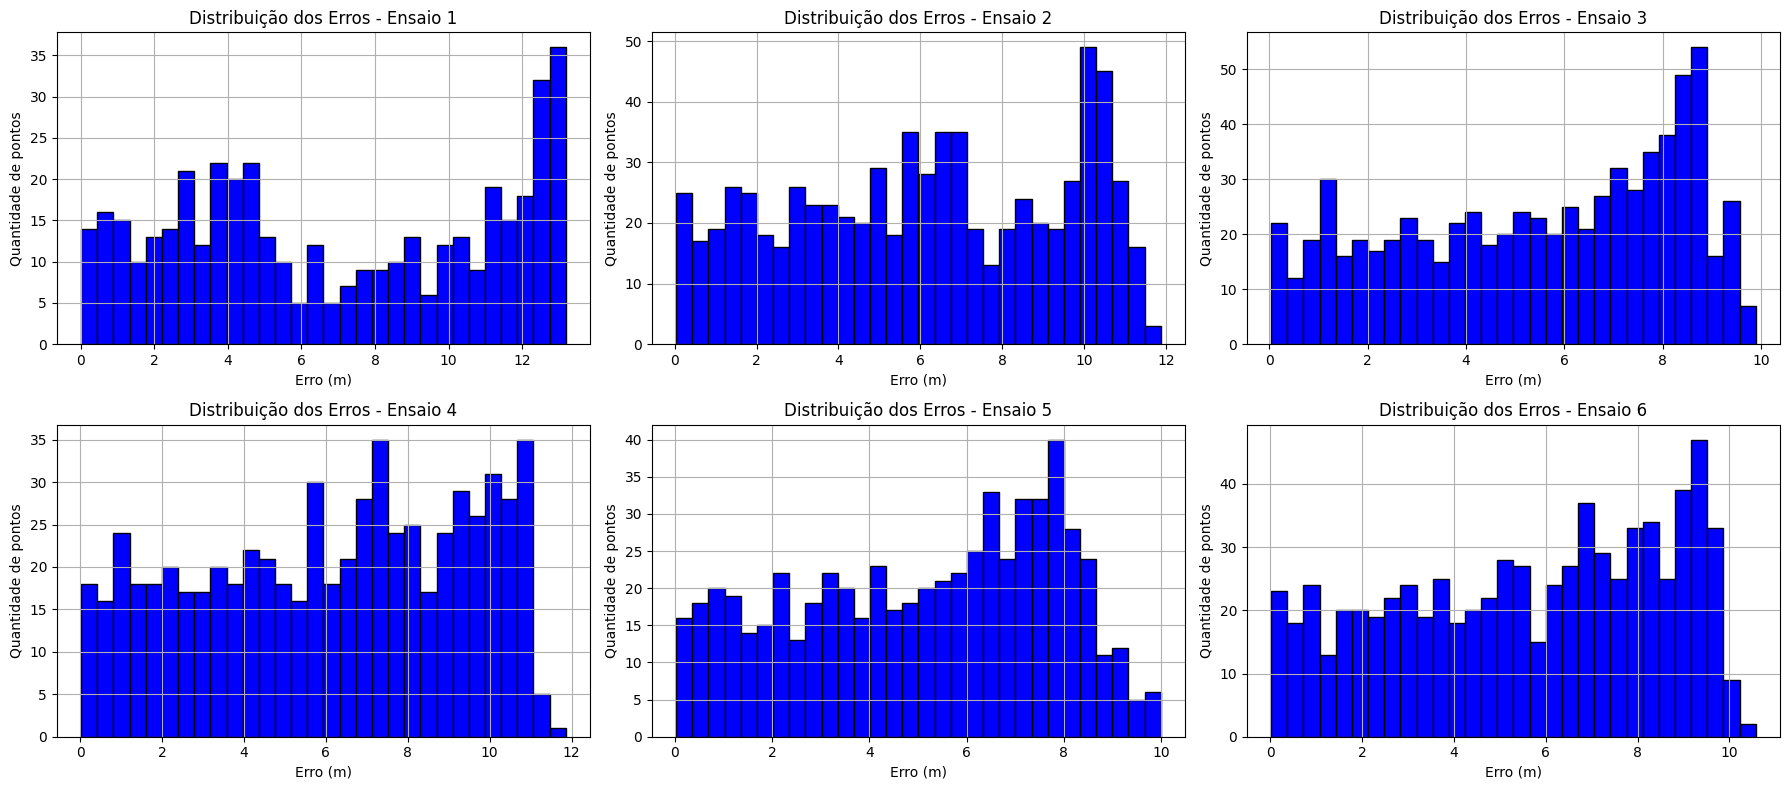

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(18, 8))
axs = axs.flatten()

# Para cada ensaio (lap) presente em laps
for i, lap_name in enumerate(laps.keys()):
    # Garante que existe análise de erro para Garmin
    if "garmin" in laps[lap_name] and "erro_analysis" in laps[lap_name]["garmin"]:
        erros = laps[lap_name]['garmin']['erro_analysis']['erros_metros']  # Erros individuais do Garmin

        # Cria o histograma para cada lap
        axs[i].hist(erros, bins=30, color='green', edgecolor='black')
        axs[i].set_title(f'Distribuição dos Erros Garmin – {labels[i]}')
        axs[i].set_xlabel('Erro (m)')
        axs[i].set_ylabel('Quantidade de pontos')
        axs[i].grid(True)

# Ajusta o layout para não sobrepor os elementos
plt.tight_layout()
plt.show()



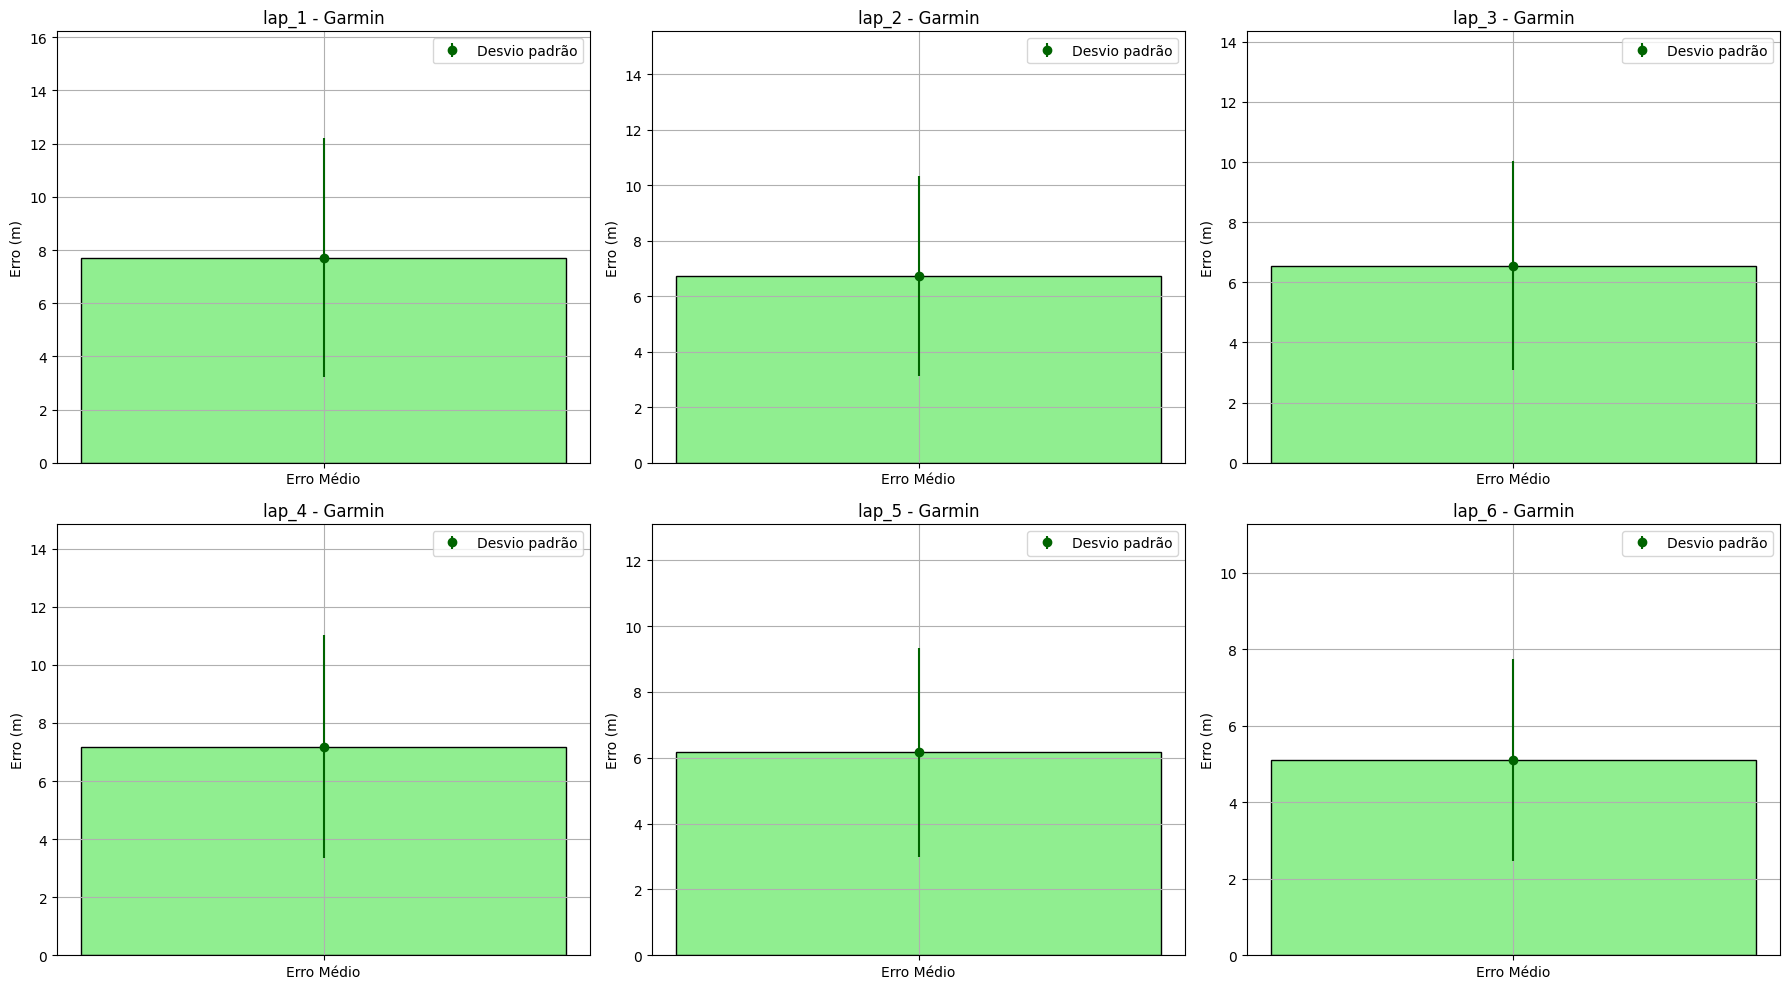

In [153]:
# Lista para extrair os erros médios e desvios diretamente do dicionário laps
laps_names = list(laps.keys())

# Plota
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

for i, lap_name in enumerate(laps_names):
    # Garante que existe análise de erro para Garmin
    if "garmin" in laps[lap_name] and "erro_analysis" in laps[lap_name]["garmin"]:
        erro_analysis = laps[lap_name]['garmin']['erro_analysis']

        media_erro = erro_analysis['media_erro_m']
        desvio_erro = erro_analysis['desvio_erro_m']
        max_erro = erro_analysis['max_erro_m']

        # Cria uma barra para o erro médio
        axs[i].bar(['Erro Médio'], [media_erro], color='lightgreen', edgecolor='black')

        # Adiciona a barra de erro representando o desvio padrão
        axs[i].errorbar('Erro Médio', media_erro, yerr=desvio_erro, fmt='o', color='darkgreen', label='Desvio padrão')

        # Ajusta o limite superior do gráfico para dar espaço ao erro máximo
        axs[i].set_ylim(0, max_erro + 1)
        axs[i].set_title(f"{lap_name} - Garmin")
        axs[i].set_ylabel("Erro (m)")

        # Adiciona a legenda e a grade
        axs[i].legend()
        axs[i].grid(True)

plt.tight_layout()
plt.show()

### Erro Mínima Distância + Ângulo

Esse erro parece mais correto pois se eu tiver um deslocamento do meu circulo e ele fizer a intersecção na referência, a intersecção será o menor valor. O correto seria tentar pelo grau que aquele ponto se encontra baseado no seu ponto central que forma o circulo para os dados

In [155]:
from geopy.distance import geodesic
import numpy as np
import pandas as pd

def calcular_angulo(ponto, centro):
    delta_x = ponto[1] - centro[1]  # longitude
    delta_y = ponto[0] - centro[0]  # latitude
    angulo_rad = np.arctan2(delta_y, delta_x)
    angulo_deg = np.degrees(angulo_rad) % 360
    return angulo_deg

# Faz uma cópia da referência e calcula ângulo dela uma única vez
ref = df_pivot.copy()
centro = (pivot_lat, pivot_long)
ref['angulo'] = ref.apply(
    lambda row: calcular_angulo((row['latitude'], row['longitude']), centro),
    axis=1
)

# Loop sobre cada volta
for lap_name in laps.keys():
    garmin = laps[lap_name]["garmin"].get("dataframe")
    if garmin is None or garmin.empty:
        continue

    erros_metros = []
    for _, ponto in garmin.iterrows():
        ponto_ensaio = (ponto['lat'], ponto['lon'])
        angulo_ensaio = calcular_angulo(ponto_ensaio, centro)

        # índice do ponto de referência com ângulo mais próximo
        idx_ref = (ref['angulo'] - angulo_ensaio).abs().idxmin()
        ponto_ref = (ref.loc[idx_ref, 'latitude'], ref.loc[idx_ref, 'longitude'])

        # adiciona distância geodésica
        erros_metros.append(geodesic(ponto_ensaio, ponto_ref).meters)

    # calcula estatísticas
    media_erro = np.mean(erros_metros)
    desvio_erro = np.std(erros_metros)
    max_erro   = np.max(erros_metros)
    min_erro   = np.min(erros_metros)

    # armazena dentro de cada volta
    laps[lap_name]["garmin"]["erro_analysis_angle"] = {
        'media_erro_m':   media_erro,
        'desvio_erro_m':  desvio_erro,
        'max_erro_m':     max_erro,
        'min_erro_m':     min_erro,
        'qtd_pontos':     len(erros_metros),
        'erros_metros':   erros_metros
    }

# Exibe o resumo
for lap_name in laps.keys():
    ana = laps[lap_name]["garmin"].get("erro_analysis_angle")
    if not ana:
        continue
    print(f"\n{lap_name} (GARMIN, erro por ângulo):")
    print(f"  ➔ Erro médio: {ana['media_erro_m']:.2f} m")
    print(f"  ➔ Desvio padrão: {ana['desvio_erro_m']:.2f} m")
    print(f"  ➔ Erro máximo: {ana['max_erro_m']:.2f} m")
    print(f"  ➔ Erro mínimo: {ana['min_erro_m']:.2f} m")
    print(f"  ➔ Pontos avaliados: {ana['qtd_pontos']}")


lap_1 (GARMIN, erro por ângulo):
  ➔ Erro médio: 7.71 m
  ➔ Desvio padrão: 4.49 m
  ➔ Erro máximo: 15.22 m
  ➔ Erro mínimo: 0.03 m
  ➔ Pontos avaliados: 720

lap_2 (GARMIN, erro por ângulo):
  ➔ Erro médio: 6.73 m
  ➔ Desvio padrão: 3.59 m
  ➔ Erro máximo: 14.54 m
  ➔ Erro mínimo: 0.02 m
  ➔ Pontos avaliados: 721

lap_3 (GARMIN, erro por ângulo):
  ➔ Erro médio: 6.55 m
  ➔ Desvio padrão: 3.47 m
  ➔ Erro máximo: 13.35 m
  ➔ Erro mínimo: 0.01 m
  ➔ Pontos avaliados: 721

lap_4 (GARMIN, erro por ângulo):
  ➔ Erro médio: 7.18 m
  ➔ Desvio padrão: 3.84 m
  ➔ Erro máximo: 13.86 m
  ➔ Erro mínimo: 0.02 m
  ➔ Pontos avaliados: 720

lap_5 (GARMIN, erro por ângulo):
  ➔ Erro médio: 6.17 m
  ➔ Desvio padrão: 3.18 m
  ➔ Erro máximo: 12.11 m
  ➔ Erro mínimo: 0.02 m
  ➔ Pontos avaliados: 720

lap_6 (GARMIN, erro por ângulo):
  ➔ Erro médio: 5.11 m
  ➔ Desvio padrão: 2.64 m
  ➔ Erro máximo: 10.28 m
  ➔ Erro mínimo: 0.04 m
  ➔ Pontos avaliados: 721


# Exportar Dicionário para JSON


In [156]:
# Função para converter DataFrames em listas de dicionários
def convert_dataframe(df):
    return df.to_dict(orient="records")

# Função de conversão geral para tipos que não são serializáveis em JSON
def default_converter(obj):
    if isinstance(obj, pd.DataFrame):  # Se for um DataFrame, converte
        return convert_dataframe(obj)
    if isinstance(obj, pd.Timestamp):  # Se for Timestamp, converte para string
        return obj.isoformat()
    return str(obj)  # Qualquer outro tipo será convertido para string

# Exporte diretamente o seu dicionário, transformando tudo em string quando necessário
with open("laps_exportado.json", "w", encoding="utf-8") as f:
    json.dump(laps, f, ensure_ascii=False, indent=2, default=default_converter)

# Comparação 3 Dispositivos